### Loading radiomics into a Pandas DataFrame

In [1]:
import os
import pandas as pd
from tqdm import tqdm

root = './data/PET-EARL/Rennes_Nifti_resampled/'

brain_fuse, liver_fuse = list(), list()
for subj in tqdm(os.listdir(root), position=0, leave=True, total=os.listdir(root).__len__()):
    sub_path = os.path.join(root, subj)
    brain_subj_meta = os.path.join(sub_path, 'brain_sphere_radiomics.csv')
    liver_subj_meta = os.path.join(sub_path, 'liver_sphere_radiomics.csv')

    if os.path.exists(brain_subj_meta):
        brain_dataframe = dataframe = pd.read_csv(brain_subj_meta)
        brain_fuse.append(dataframe)

    if os.path.exists(liver_subj_meta):
        liver_dataframe = dataframe = pd.read_csv(liver_subj_meta)
        liver_fuse.append(dataframe)

brain_final_dataframe = pd.concat(brain_fuse, axis=0)
liver_final_dataframe = pd.concat(liver_fuse, axis=0)

100%|██████████| 76/76 [00:00<00:00, 135.30it/s]


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import math
import seaborn as sns
import matplotlib.ticker as mtick

def plot_overlap_grid(dataframe, features_list, bw_adjust=0.1):
    """
    Affiche une grille d'overlap avec un ZOOM INTELLIGENT sur le cluster principal.
    Les outliers extrêmes (top/bottom 1%) sont ignorés pour le calcul de l'axe X.
    """
    
    valid_features = [f for f in features_list if f in dataframe.columns]
    
    if not valid_features:
        print("Aucune feature valide trouvée.")
        return

    n_cols = 3
    n_rows = math.ceil(len(valid_features) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(valid_features):
        ax = axes[i]
        
        # --- 1. Extraction ---
        data_pet = dataframe[dataframe['Modality'] == 'PET'][feature_name].dropna()
        data_earl = dataframe[dataframe['Modality'] == 'EARL'][feature_name].dropna()
        
        if len(data_pet) < 2 or len(data_earl) < 2:
            ax.text(0.5, 0.5, "Pas assez de données", ha='center')
            continue

        # --- 2. Configuration KDE ---
        try:
            kde_pet_func = gaussian_kde(data_pet, bw_method=bw_adjust)
            kde_earl_func = gaussian_kde(data_earl, bw_method=bw_adjust)
            
            # --- 3. Grille haute résolution (ZOOM ROBUSTE) ---
            # <--- MODIFICATION ICI --->
            # On combine les données pour trouver l'échelle commune
            combined_data = np.concatenate([data_pet, data_earl])
            
            # Au lieu de min/max, on prend le 0.5ème et 99.5ème percentile
            # Cela garde 99% des données visibles et coupe les outliers lointains
            p_min = np.percentile(combined_data, 0.5) 
            p_max = np.percentile(combined_data, 99.5)
            
            # On ajoute une marge de 10% autour de ce cluster principal
            span = p_max - p_min
            if span == 0: span = 1.0 # Sécurité si feature constante
                
            padding = span * 0.1
            grid_start = p_min - padding
            grid_end = p_max + padding
            
            grid = np.linspace(grid_start, grid_end, 1000)
            # <--- FIN MODIFICATION --->
            
            y_pet = kde_pet_func(grid)
            y_earl = kde_earl_func(grid)
            
            # --- 4. Score Overlap ---
            intersection = np.minimum(y_pet, y_earl)
            ovl_score = np.trapz(intersection, grid)
            
            # --- 5. Affichage ---
            ax.plot(grid, y_pet, color='royalblue', label='PET Standard', linewidth=2)
            ax.fill_between(grid, y_pet, alpha=0.1, color='royalblue')
            
            ax.plot(grid, y_earl, color='darkorange', label='EARL', linewidth=2)
            ax.fill_between(grid, y_earl, alpha=0.1, color='darkorange')
            
            ax.fill_between(grid, 0, intersection, color='gray', alpha=0.2, hatch='////',
                            label=f'Overlap (OVL={ovl_score:.2f})')
            
            # Esthétique
            clean_name = feature_name.replace('original_firstorder_', '').replace('original_glcm_', '').replace('original_glrlm_', '')
            clean_name = clean_name.replace('RobustMeanAbsoluteDeviation', 'RMAD') # raccourci fréquent
            
            ax.set_title(clean_name, fontsize=12, fontweight='bold')
            
            # Notation scientifique si les axes sont grands (ex: Energy)
            # On vérifie sur les bornes calculées (p_max)
            if 'Energy' in feature_name or abs(p_max) > 1000:
                ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                
            ax.legend(loc='upper right', fontsize=9)
            ax.grid(True, linestyle=':', alpha=0.5)
            ax.set_yticks([])
            ax.set_ylabel('')
            
            # Force les limites X pour ne pas afficher le vide si le KDE bave un peu
            ax.set_xlim(grid_start, grid_end)
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Erreur: {str(e)}", ha='center', fontsize=8)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_combo_box_slope(dataframe, features_list, n_points=200, point_size=2, outlier_sigma=3.0):
    """
    Génère un Combo Plot (Boxplot + Slope Chart) avec gestion des outliers.
    
    Args:
        dataframe (pd.DataFrame): Données complètes.
        features_list (list): Liste des features à afficher.
        n_points (int): Nombre de points individuels à afficher (background).
        point_size (float): Taille des points (s).
        outlier_sigma (float): Seuil en écart-type (ex: 3.0). 
                               Les valeurs > mean + 3*std sont "écrasées" sur la bordure.
    """
    
    # Filtrage des features valides
    valid_features = [f for f in features_list if f in dataframe.columns]
    if not valid_features:
        print("Aucune feature valide.")
        return

    # Configuration Grille : 2 Lignes (Haut=Box, Bas=Slope) x N Colonnes
    n_cols = len(valid_features)
    # Si beaucoup de features, on pourrait diviser en plusieurs figures, 
    # mais ici on fait une large figure unique comme demandé.
    fig, axes = plt.subplots(2, n_cols, figsize=(6 * n_cols, 10), 
                             gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.3})
    
    # Gestion du cas où il n'y a qu'une seule feature (axes n'est pas une matrice 2D)
    if n_cols == 1:
        axes = axes.reshape(2, 1)

    # Préparation de l'échantillon aléatoire pour l'affichage (Background)
    all_subjects = dataframe['Subject_ID'].unique()
    n_sample = min(n_points, len(all_subjects))
    random_subjects = np.random.choice(all_subjects, n_sample, replace=False)
    
    for i, feature in enumerate(valid_features):
        ax_box = axes[0, i]   # Étage du haut
        ax_slope = axes[1, i] # Étage du bas
        
        # --- 1. CALCULS STATISTIQUES (Sur TOUT le dataset) ---
        # On calcule les bornes globales pour le "Clamping" (Écrasement)
        # On combine PET et EARL pour avoir une échelle commune
        vals_all = dataframe[feature]
        mean_global = vals_all.mean()
        std_global = vals_all.std()
        
        limit_low = mean_global - outlier_sigma * std_global
        limit_high = mean_global + outlier_sigma * std_global
        
        # --- 2. ÉTAGE HAUT : BOXPLOT + STRIPPLOT ---
        
        # A. Boxplot (Données Brutes)
        # On cache les fliers (outliers) du boxplot car on va les afficher nous-mêmes via le strip
        sns.boxplot(data=dataframe, x='Modality', y=feature, ax=ax_box,
                    palette={'PET': 'skyblue', 'EARL': 'orange'},
                    width=0.4, showfliers=False, hue='Modality',
                    boxprops=dict(alpha=0.6, edgecolor='black'))
        
        # B. Stripplot (Données "Clamped" et Échantillonnées)
        # On filtre pour ne garder que les patients de l'échantillon
        df_sample = dataframe[dataframe['Subject_ID'].isin(random_subjects)].copy()
        
        # CLAMPING : On écrase les valeurs qui dépassent les bornes
        # clip() remplace tout ce qui est < low par low, et > high par high
        df_sample[feature] = df_sample[feature].clip(lower=limit_low, upper=limit_high)
        
        # Affichage des points
        sns.stripplot(data=df_sample, x='Modality', y=feature, ax=ax_box,
                      color='black', size=point_size, alpha=0.4, jitter=0.2, zorder=10)
        
        # Gestion des limites visuelles
        # On ajoute une petite marge (5%) au-delà du seuil pour voir les points écrasés sur le bord
        margin = (limit_high - limit_low) * 0.05
        ax_box.set_ylim(limit_low - margin, limit_high + margin)
        
        # Décoration visuelle pour indiquer le seuil
        ax_box.axhline(limit_high, color='red', linestyle=':', alpha=0.3, linewidth=1)
        ax_box.axhline(limit_low, color='red', linestyle=':', alpha=0.3, linewidth=1)
        
        clean_name = feature.replace('original_firstorder_', '').replace('original_glcm_', '').replace('original_glrlm_', '')
        
        ax_box.set_title(f"Dist. : {clean_name}", fontsize=12, fontweight='bold')
        ax_box.set_xlabel('')
        ax_box.set_ylabel('')
        ax_box.grid(axis='y', linestyle='--', alpha=0.5)

        # --- 3. ÉTAGE BAS : SLOPE CHART ---
        
        # Pivot des données (Large)
        df_pivot = dataframe.pivot(index='Subject_ID', columns='Modality', values=feature).dropna()
        
        # A. Moyenne Globale (Sur TOUT le dataset)
        mean_pet = df_pivot['PET'].mean()
        mean_earl = df_pivot['EARL'].mean()
        
        # B. Lignes de Fond (Échantillon Seulement)
        df_slope_sample = df_pivot.loc[df_pivot.index.intersection(random_subjects)].copy()
        
        # On applique aussi le clamping aux lignes grises pour qu'elles ne sortent pas du graph
        df_slope_sample['PET'] = df_slope_sample['PET'].clip(lower=limit_low, upper=limit_high)
        df_slope_sample['EARL'] = df_slope_sample['EARL'].clip(lower=limit_low, upper=limit_high)
        
        # Tracé vectorisé (plus rapide que boucle)
        x_coords = [0, 1]
        y_coords = df_slope_sample[['PET', 'EARL']].T.values # Shape (2, N)
        ax_slope.plot(x_coords, y_coords, color='gray', alpha=0.2, linewidth=1)
        
        # C. Ligne Rouge (Moyenne Globale)
        ax_slope.plot([0, 1], [mean_pet, mean_earl], color='crimson', linewidth=4, marker='o', markersize=8, zorder=10)
        
        # D. Points Moyens et Annotation
        ax_slope.scatter([0], [mean_pet], color='skyblue', s=150, zorder=11, edgecolors='k')
        ax_slope.scatter([1], [mean_earl], color='orange', s=150, zorder=11, edgecolors='k')
        
        pct = ((mean_earl - mean_pet) / mean_pet) * 100
        mid_y = (mean_pet + mean_earl) / 2
        # Si le texte sort des bornes à cause du clamping, on le recentre
        mid_y = max(limit_low, min(limit_high, mid_y))

        # CALCUL OFFSET DYNAMIQUE
        # On calcule l'amplitude totale des données sur ce graphique
        data_range = df_pivot.max().max() - df_pivot.min().min()
        # On ajoute 10% de cette amplitude pour décaler le texte vers le haut
        text_offset = data_range * 0.10
        
        ax_slope.text(0.5, mid_y + text_offset, f"{pct:+.1f}%", ha='center', va='center',
                      color='crimson', fontweight='bold', 
                      bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, pad=2))

        # Paramètres Axes
        ax_slope.set_title(f"Slope : {clean_name}", fontsize=12, fontweight='bold')
        ax_slope.set_xticks([0, 1])
        ax_slope.set_xticklabels(['PET', 'EARL'], fontweight='bold')
        ax_slope.set_xlim(-0.2, 1.2)
        
        # On force les mêmes limites Y qu'en haut pour la cohérence
        ax_slope.set_ylim(limit_low - margin, limit_high + margin)
        ax_slope.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Notation scientifique pour grandes valeurs
        if 'Energy' in feature or abs(mean_pet) > 1000:
            ax_box.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax_slope.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.suptitle(f"Combo Plot : Boxplot (Haut) & Slope Chart (Bas)\nPoints affichés : {n_sample} | Outliers clippés à {outlier_sigma} SD", y=0.95, fontsize=16)
    # plt.tight_layout() # Parfois conflictuel avec suptitle, on ajuste manuellement si besoin
    plt.show()

def plot_delta_boxplot(dataframe, features_list, n_points=200, ylim=None):
    """
    Affiche la variation relative (EARL - PET) / PET pour plusieurs features sur un seul graphique.
    
    Approche :
    - Boxplot fin (width=0.2) pour les statistiques.
    - Stripplot centré (jitter=0.05) pour les données brutes.
    - Limites Y automatiques robustes (1er-99ème percentile) ou manuelles.
    """
    
    # 1. Filtrage et Préparation des données
    valid_features = [f for f in features_list if f in dataframe.columns]
    if not valid_features:
        print("Aucune feature valide.")
        return

    # Pivot pour calcul vectorisé
    df_pivot = dataframe.pivot(index='Subject_ID', columns='Modality')
    
    plot_data = []
    
    for feature in valid_features:
        try:
            # Calcul du Delta : (EARL - PET) / PET
            pet = df_pivot[feature]['PET']
            earl = df_pivot[feature]['EARL']
            delta = (earl - pet) / pet
            
            # Nom propre pour l'affichage
            clean_name = feature.replace('original_firstorder_', '').replace('original_glcm_', '').replace('original_glrlm_', '')
            clean_name = clean_name.replace('RobustMeanAbsoluteDeviation', 'RMAD')
            
            # Stockage
            temp_df = pd.DataFrame({'Delta': delta, 'Feature': clean_name})
            plot_data.append(temp_df)
        except KeyError:
            continue
            
    df_all = pd.concat(plot_data, ignore_index=True)
    
    # Échantillonnage pour les points (pour alléger le graphique si N grand)
    # On prend n_points au hasard par feature
    if n_points < len(dataframe):
        df_points = df_all.groupby('Feature').sample(n=n_points, random_state=42)
    else:
        df_points = df_all

    # 2. Configuration du Plot
    # Largeur dynamique : s'adapte au nombre de features
    plt.figure(figsize=(max(10, len(valid_features) * 1.2), 8))
    
    # Ligne de référence Zéro (Discrète)
    plt.axhline(0, color='#444444', linestyle='--', linewidth=1, alpha=0.7, zorder=0)

    # A. Le Boxplot (La Statistique)
    # width=0.2 : Boîtes fines comme demandé
    # showfliers=False : On cache les points automatiques du boxplot car on va mettre les nôtres
    sns.boxplot(data=df_all, x='Feature', y='Delta',
                width=0.2, 
                color='white', 
                showfliers=False,
                boxprops=dict(alpha=1.0, edgecolor='black', linewidth=1.2),
                medianprops=dict(color='crimson', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.2),
                capprops=dict(color='black', linewidth=1.2),
                zorder=5)

    # B. Le Stripplot (Les Données)
    # jitter=0.05 : Très peu de dispersion latérale -> Points centrés sur la boîte
    sns.stripplot(data=df_points, x='Feature', y='Delta',
                  color='black', 
                  size=2.5, 
                  alpha=0.3, 
                  jitter=0.05, 
                  zorder=10)

    # 3. Formatage et Limites
    ax = plt.gca()
    
    # Axe Y en Pourcentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
    
    # Gestion des limites Y (Zoom intelligent)
    if ylim is not None:
        plt.ylim(ylim)
    else:
        # Calcul automatique robuste : On regarde le range 1% - 99%
        # Cela évite qu'un outlier unique à +500% n'écrase tout le graphique
        y_low = df_all['Delta'].quantile(0.01)
        y_high = df_all['Delta'].quantile(0.99)
        
        # On ajoute une petite marge de 10%
        margin = (y_high - y_low) * 0.1
        
        # Sécurité si range nul
        if margin == 0: margin = 0.1
            
        plt.ylim(y_low - margin, y_high + margin)

    # Labels et Titres
    plt.title("Variations Relatives : (EARL - PET) / PET", fontsize=16, fontweight='bold')
    plt.ylabel("Variation Relative", fontsize=12)
    plt.xlabel("")
    
    # Rotation des labels X pour lisibilité
    plt.xticks(rotation=45, ha='right', fontsize=11, fontweight='bold')
    
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_scatter_identity(dataframe, features_list, zoom_percentile=0.5):
    """
    Scatter Plot (PET vs EARL) avec Zoom Robuste sur le cluster principal.
    
    Args:
        dataframe: Le dataframe contenant les données.
        features_list: Liste des features.
        zoom_percentile (float): Pourcentage de données à ignorer en haut et en bas pour le zoom.
                                 0.5 signifie qu'on affiche l'intervalle [0.5%, 99.5%].
                                 Cela élimine les outliers visuels extrêmes.
    """
    
    valid_features = [f for f in features_list if f in dataframe.columns]
    if not valid_features:
        print("Aucune feature valide.")
        return

    # Géométrie (Max 4 colonnes)
    n_cols = 4
    n_rows = math.ceil(len(valid_features) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6 * n_rows))
    axes = axes.flatten()
    
    df_pivot = dataframe.pivot(index='Subject_ID', columns='Modality')

    for i, feature in enumerate(valid_features):
        ax = axes[i]
        
        try:
            # 1. Extraction
            x = df_pivot[feature]['PET']
            y = df_pivot[feature]['EARL']
            mask = ~np.isnan(x) & ~np.isnan(y)
            x, y = x[mask], y[mask]
            
            # 2. Calcul des Limites Robustes (Le Zoom Intelligent)
            # On combine X et Y pour trouver une échelle commune qui englobe le cluster principal
            combined_data = np.concatenate([x, y])
            
            # On cherche les bornes qui contiennent 99% des données (si zoom_percentile=0.5)
            # nanpercentile ignore les nans au cas où
            lim_min = np.nanpercentile(combined_data, zoom_percentile)
            lim_max = np.nanpercentile(combined_data, 100 - zoom_percentile)
            
            # On ajoute une petite marge de 5% autour de ce cluster pour qu'il ne touche pas les bords
            margin = (lim_max - lim_min) * 0.05
            view_min = lim_min - margin
            view_max = lim_max + margin
            
            # 3. Scatter Plot
            # On affiche TOUS les points, même les outliers (ceux hors champ seront juste coupés par le xlim/ylim)
            ax.scatter(x, y, alpha=0.4, c='teal', edgecolor='k', s=20, linewidth=0.5)
            
            # 4. Ligne d'Identité (Diagonale)
            # On la trace sur toute la vue calculée
            ax.plot([view_min, view_max], [view_min, view_max], 
                    color='crimson', linestyle='--', linewidth=2, label='Identité')
            
            # 5. Calcul de Corrélation (Sur TOUTES les données, même cachées)
            # C'est important scientifiquement de ne pas mentir sur le R
            corr = np.corrcoef(x, y)[0, 1]
            
            # Annotation
            ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
                    fontsize=12, fontweight='bold', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))
            
            # Esthétique
            clean_name = feature.replace('original_firstorder_', '').replace('original_glcm_', '').replace('original_glrlm_', '')
            clean_name = clean_name.replace('RobustMeanAbsoluteDeviation', 'RMAD')
            
            ax.set_title(clean_name, fontsize=14, fontweight='bold')
            ax.set_xlabel('PET Standard', fontweight='bold')
            ax.set_ylabel('EARL', fontweight='bold')
            
            # 6. Application du Zoom
            ax.set_xlim(view_min, view_max)
            ax.set_ylim(view_min, view_max)
            
            ax.grid(True, linestyle=':', alpha=0.6)
            
            # Notation scientifique si les axes sont grands
            if abs(view_max) > 1000 or abs(view_max) < 0.001:
                ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                
        except Exception as e:
            ax.text(0.5, 0.5, "Données insuffisantes", ha='center')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.suptitle(f"Scatter Plot : Cluster Principal (Zoom {100-2*zoom_percentile}%)", y=1.02, fontsize=18)
    plt.show()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats

def plot_bland_altman_slope(dataframe, features_list):
    """
    Affiche une grille de Bland-Altman avec :
    - Axe X : Moyenne ((A+B)/2)
    - Axe Y : Différence (B-A)
    - Lignes : Biais (Rouge), LoA (Gris), et surtout la PENTE (Vert) pour voir le biais proportionnel.
    """
    
    valid_features = [f for f in features_list if f in dataframe.columns]
    if not valid_features:
        print("Aucune feature valide.")
        return

    # Géométrie (Max 3 ou 4 colonnes, ici 3 pour que les BA soient lisibles car souvent carrés)
    n_cols = 3 
    n_rows = math.ceil(len(valid_features) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    axes = axes.flatten()
    
    df_pivot = dataframe.pivot(index='Subject_ID', columns='Modality')

    for i, feature in enumerate(valid_features):
        ax = axes[i]
        
        try:
            # 1. Données
            data_pet = df_pivot[feature]['PET']
            data_earl = df_pivot[feature]['EARL']
            
            mask = ~np.isnan(data_pet) & ~np.isnan(data_earl)
            d1, d2 = data_pet[mask], data_earl[mask]
            
            # 2. Calculs Bland-Altman
            means = (d1 + d2) / 2
            diffs = d2 - d1          # EARL - PET
            
            mean_bias = np.mean(diffs)
            std_bias = np.std(diffs)
            upper_loa = mean_bias + 1.96 * std_bias
            lower_loa = mean_bias - 1.96 * std_bias
            
            # 3. Calcul de la Pente (Régression Linéaire sur le BA)
            # Cela permet de voir le "Proportional Bias"
            slope, intercept, r_value, p_value, std_err = stats.linregress(means, diffs)
            
            # Ligne de régression à tracer
            x_range = np.linspace(means.min(), means.max(), 100)
            y_trend = slope * x_range + intercept
            
            # 4. Plot
            # Nuage de points
            ax.scatter(means, diffs, alpha=0.5, c='steelblue', s=20, edgecolor='none')
            
            # Ligne de Biais (Rouge Fixe)
            ax.axhline(mean_bias, color='crimson', linestyle='-', linewidth=2, label=f'Biais: {mean_bias:.2f}')
            
            # Ligne Zéro (Référence)
            ax.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.5)
            
            # Limites d'Accord (LoA - Gris)
            ax.axhline(upper_loa, color='gray', linestyle='--', linewidth=1.5)
            ax.axhline(lower_loa, color='gray', linestyle='--', linewidth=1.5)
            
            # --- LA PENTE (Slope) ---
            # On la trace en Vert (ou Violet) pour la distinguer du biais
            trend_label = f"Pente: {slope:.3f} (p={p_value:.3f})"
            ax.plot(x_range, y_trend, color='forestgreen', linestyle='-', linewidth=2, label=trend_label)
            
            # Zone de confiance LoA (Visuel)
            ax.axhspan(lower_loa, upper_loa, color='gray', alpha=0.1)
            
            # 5. Annotations
            # Affichage des valeurs LoA sur le côté droit
            x_max = means.max()
            ax.text(x_max, upper_loa, f'+1.96SD\n{upper_loa:.2f}', ha='left', va='center', fontsize=8, color='gray')
            ax.text(x_max, lower_loa, f'-1.96SD\n{lower_loa:.2f}', ha='left', va='center', fontsize=8, color='gray')
            
            # Esthétique
            clean_name = feature.replace('original_firstorder_', '').replace('original_glcm_', '').replace('original_glrlm_', '')
            clean_name = clean_name.replace('RobustMeanAbsoluteDeviation', 'RMAD')
            
            ax.set_title(clean_name, fontsize=12, fontweight='bold')
            ax.set_xlabel('Moyenne Magnitude')
            ax.set_ylabel('Différence (EARL - PET)')
            
            # Légende en bas ou en haut selon la place
            ax.legend(loc='best', fontsize=9, frameon=True)
            ax.grid(True, linestyle=':', alpha=0.5)
            
            # Notation scientifique si les axes sont grands
            if abs(means.max()) > 1000:
                ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                
        except Exception as e:
            ax.text(0.5, 0.5, "Erreur calcul", ha='center')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.suptitle("Analyse Bland-Altman & Biais Proportionnel (Pente)", y=1.02, fontsize=16)
    plt.show()

In [3]:
# --- 1. FIRST ORDER (9 Features) ---
# Focus : Quantification (Median/Energy), Bruit (Entropy/Uniformity), Forme de l'histogramme (Skew/Kurt)
FEATURES_FIRSTORDER = [
    'original_firstorder_Entropy',                    # Mesure du désordre (Bruit) -> Doit Baisser
    'original_firstorder_Uniformity',                 # Mesure de l'ordre -> Doit Monter
    'original_firstorder_RobustMeanAbsoluteDeviation',# Dispersion robuste -> Doit Baisser
    'original_firstorder_MeanAbsoluteDeviation',      # Dispersion globale -> Doit Baisser
    'original_firstorder_Median',                     # Intensité Moyenne (Biologie) -> Doit rester Stable
    'original_firstorder_Maximum',                    # Pics d'intensité (Points chauds) -> Doit Baisser (si PSF)
    'original_firstorder_Kurtosis',                   # Aplatissement de la courbe -> Doit se normaliser
    'original_firstorder_Skewness',                   # Asymétrie de la courbe -> Doit tendre vers 0
    'original_firstorder_Energy'                      # Masse totale du signal -> Doit rester cohérente
]

# --- 2. GLCM (8 Features) ---
# Focus : Texture fine, Contraste local et Intensité moyenne
FEATURES_GLCM = [
    'original_glcm_JointEntropy',    # Complexité texturelle -> Doit Baisser
    'original_glcm_Contrast',        # Différence d'intensité locale -> Doit Baisser
    'original_glcm_Idm',             # Homogénéité (Inverse Diff Moment) -> Doit Monter
    'original_glcm_JointEnergy',     # Uniformité texturelle (Ang. Sec. Moment) -> Doit Monter
    'original_glcm_ClusterShade',    # Asymétrie de la texture -> Stable ou légère baisse
    'original_glcm_Correlation',     # Structure linéaire -> Stable
    'original_glcm_JointAverage',    # Proxy du SUV Mean -> Stable (Ligne Identité parfaite attendue)
    'original_glcm_SumAverage'       # Proxy du SUV Mean -> Stable
]

# --- 3. GLRLM (5 Features) ---
# Focus : "Courses" de pixels (Run Length). 
# Idée : Le bruit crée des courses courtes. Le lissage crée des courses longues.
FEATURES_GLRLM = [
    'original_glrlm_ShortRunEmphasis',       # (SRE) Prédominance des lignes courtes (Bruit) -> Doit Baisser NETTEMENT
    'original_glrlm_LongRunEmphasis',        # (LRE) Prédominance des lignes longues (Lisse) -> Doit Monter
    'original_glrlm_GrayLevelNonUniformity', # (GLN) Variabilité des gris -> Doit Baisser
    'original_glrlm_RunLengthNonUniformity', # (RLN) Variabilité des longueurs -> Doit Baisser
    'original_glrlm_HighGrayLevelRunEmphasis'# (HGLRE) Texture dans les zones chaudes -> À surveiller (Conservation du signal tumeur)
]

## Radiomiques de firstorder

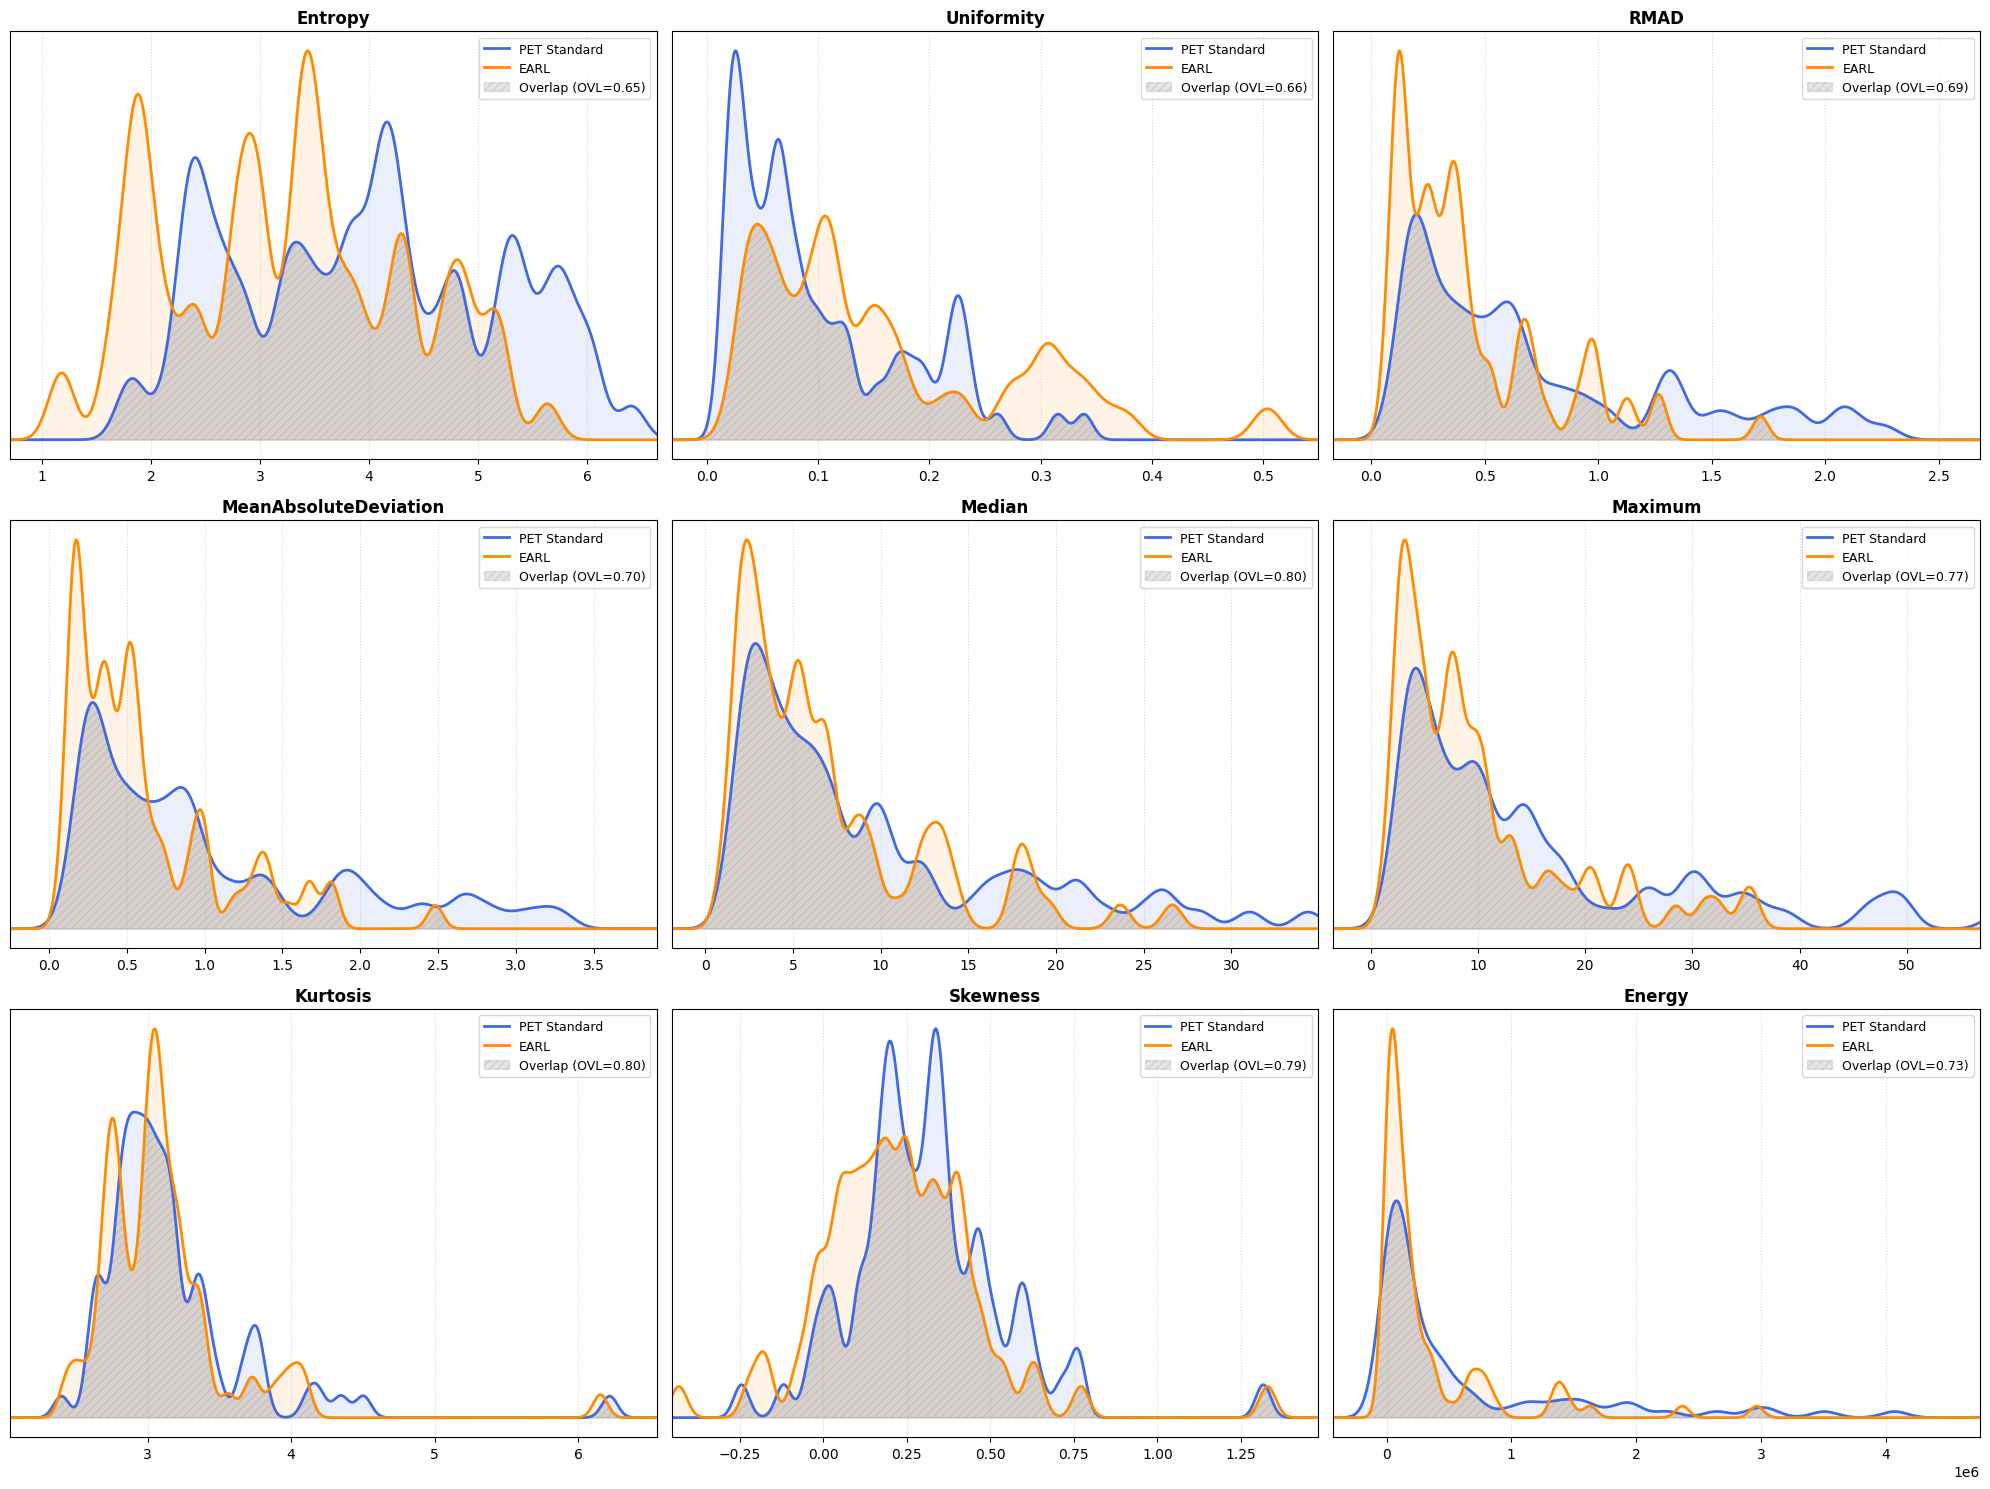

In [4]:
# Plot First Order Features for Brain
plot_overlap_grid(liver_final_dataframe, FEATURES_FIRSTORDER, bw_adjust=0.1)

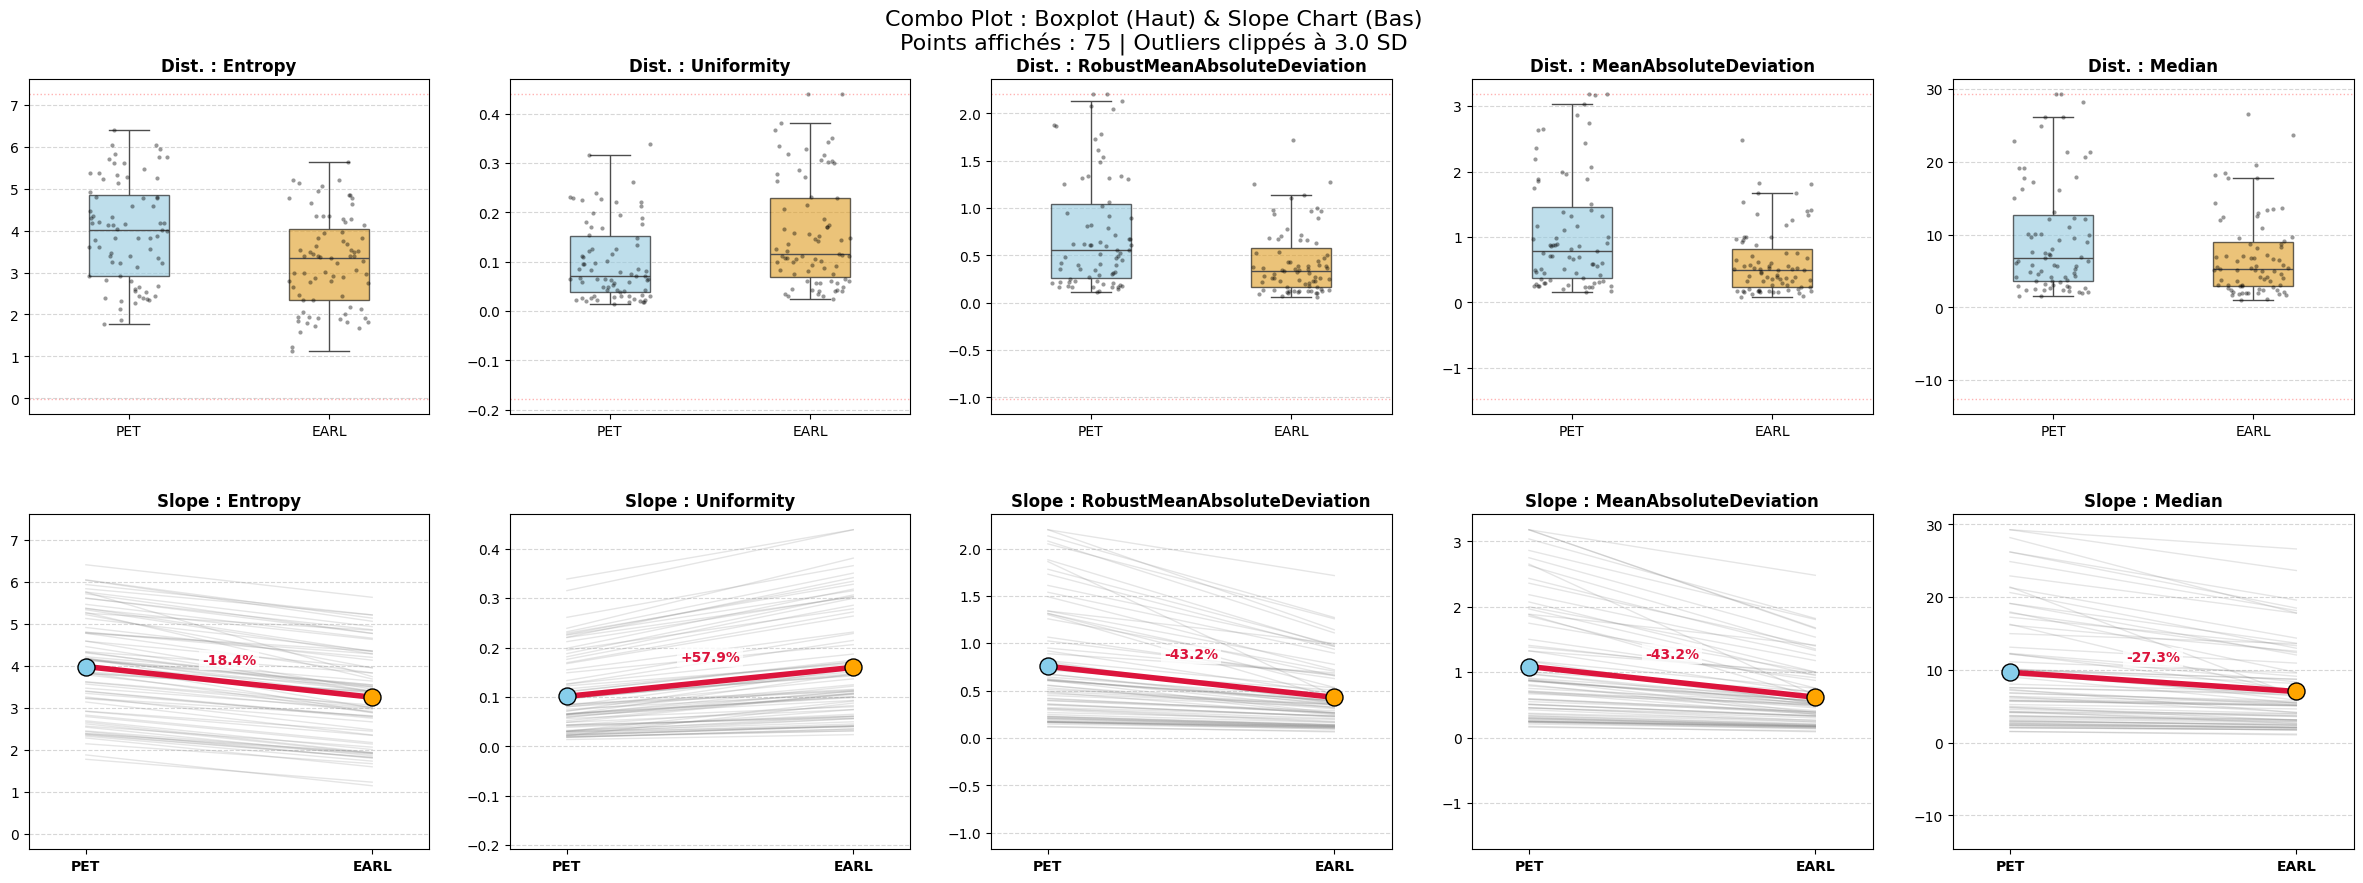

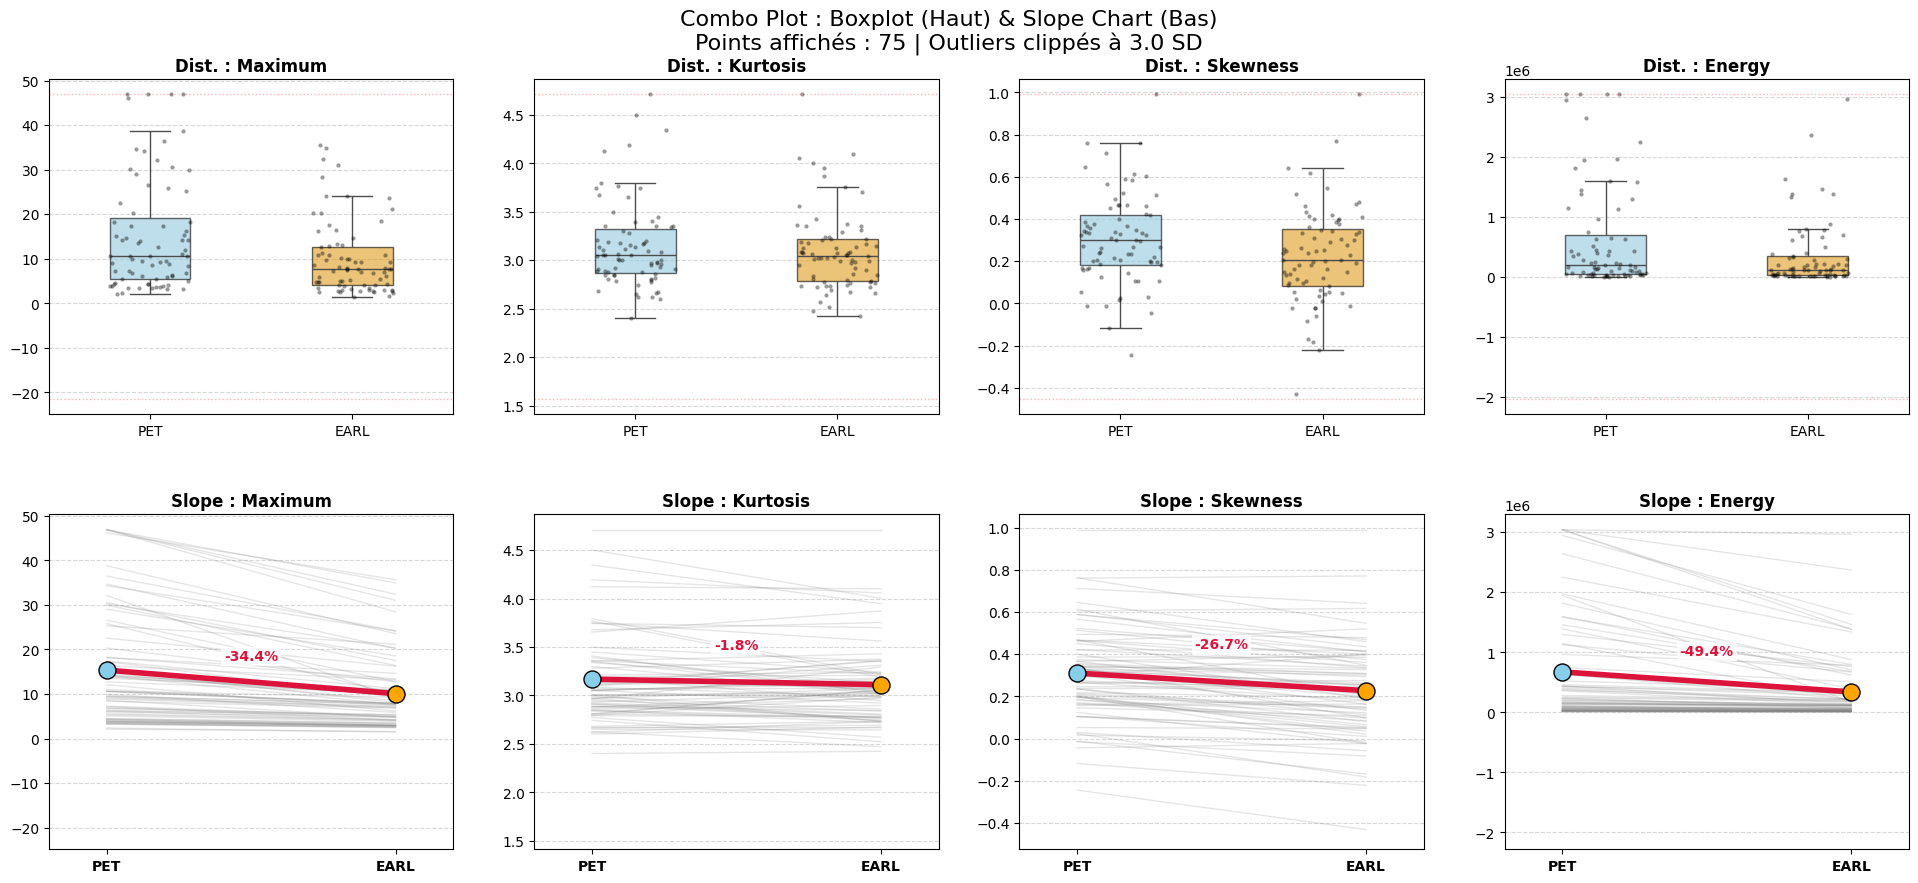

In [123]:
plot_combo_box_slope(liver_final_dataframe, FEATURES_FIRSTORDER[:5], n_points=77, point_size=3, outlier_sigma=3.0)
plot_combo_box_slope(liver_final_dataframe, FEATURES_FIRSTORDER[5:], n_points=77, point_size=3, outlier_sigma=3.0)

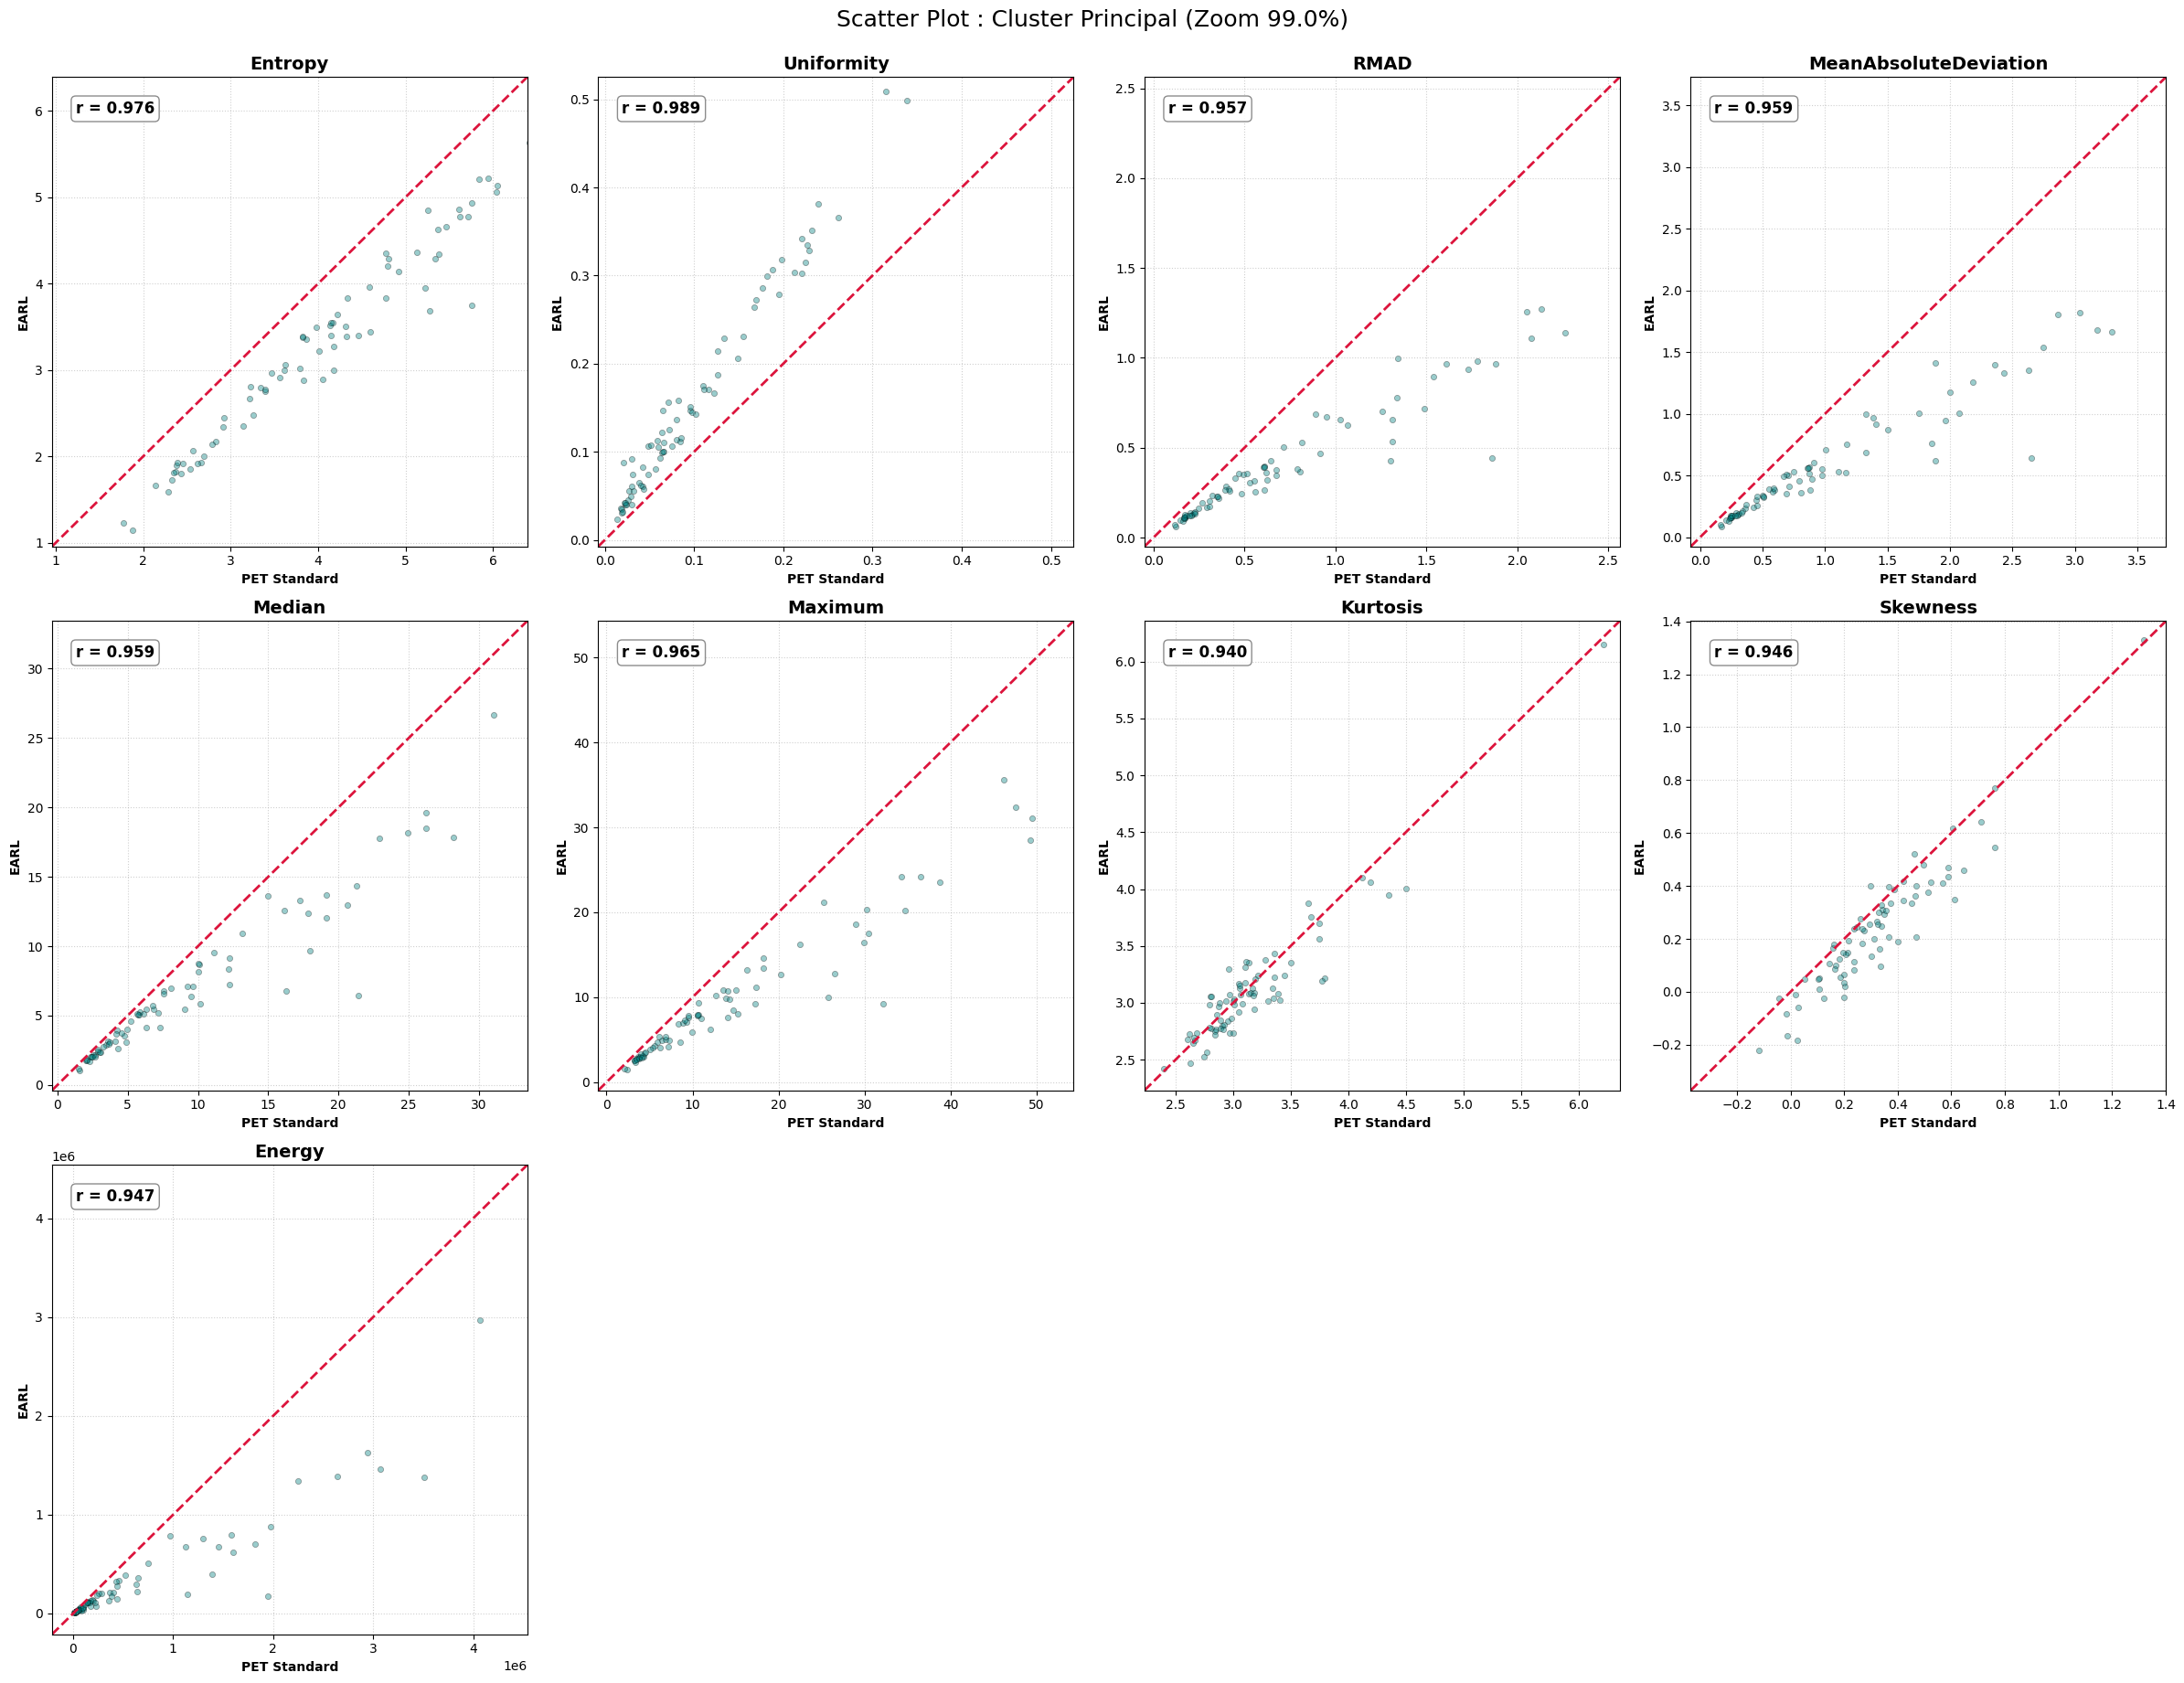

In [19]:
plot_scatter_identity(liver_final_dataframe, FEATURES_FIRSTORDER, zoom_percentile=0.5)

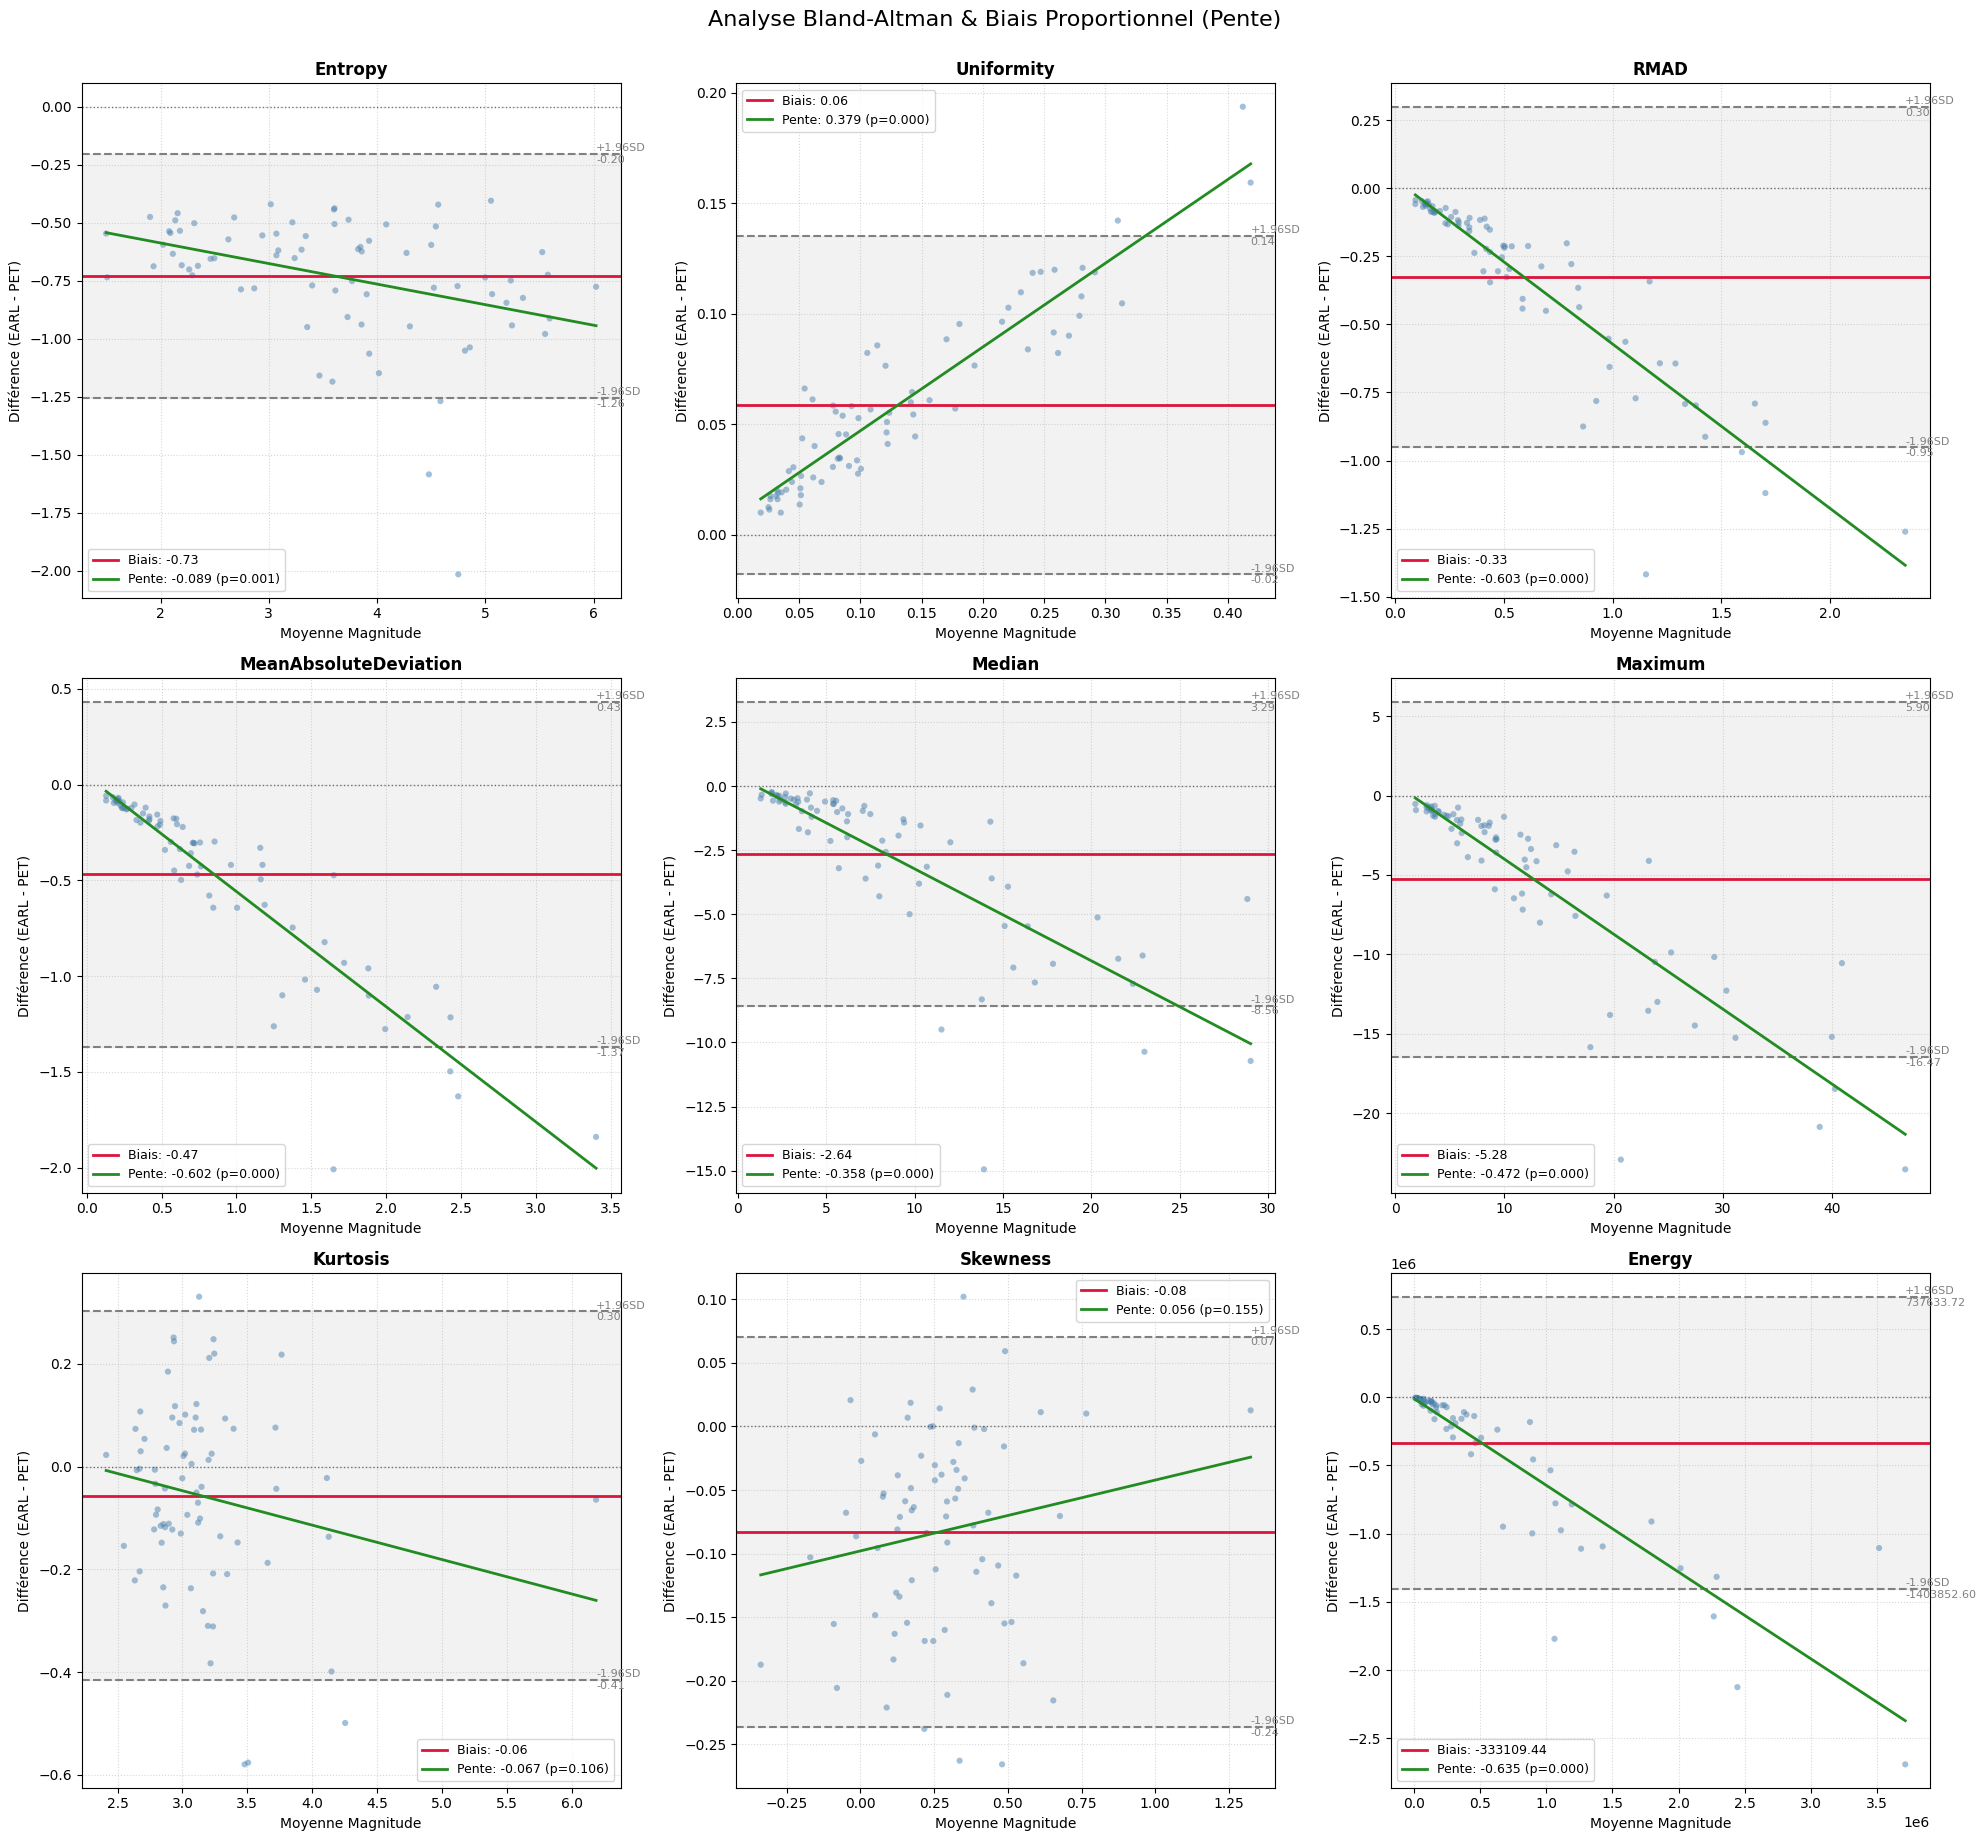

In [126]:
plot_bland_altman_slope(liver_final_dataframe, FEATURES_FIRSTORDER)

## Features GLCM

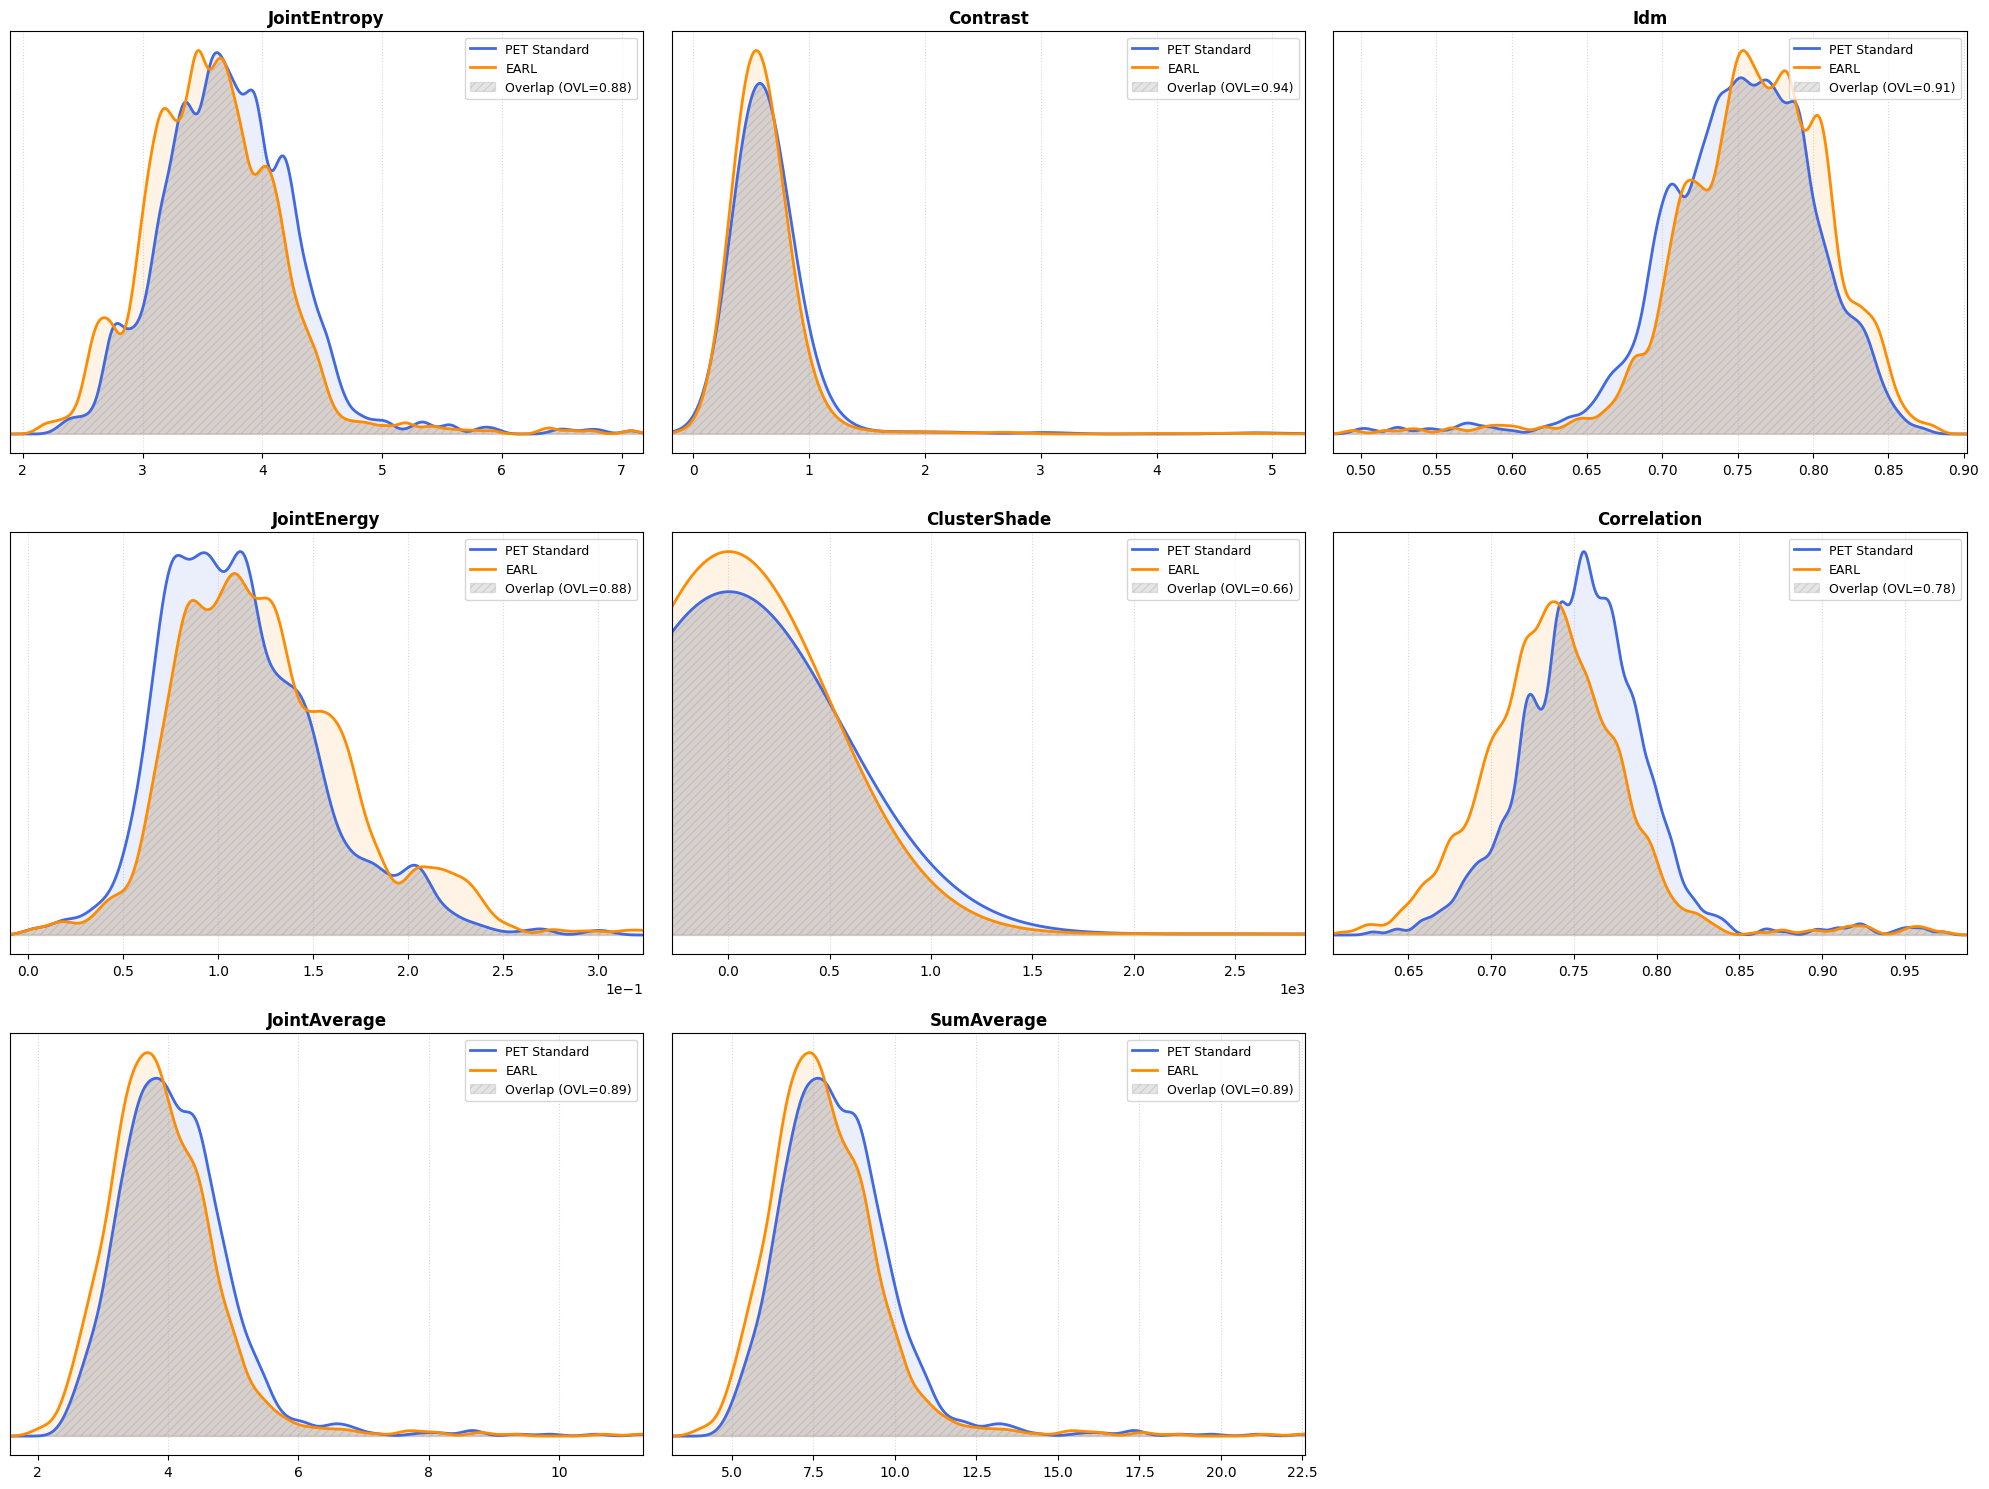

In [12]:
plot_overlap_grid(liver_final_dataframe, FEATURES_GLCM, bw_adjust=0.1)

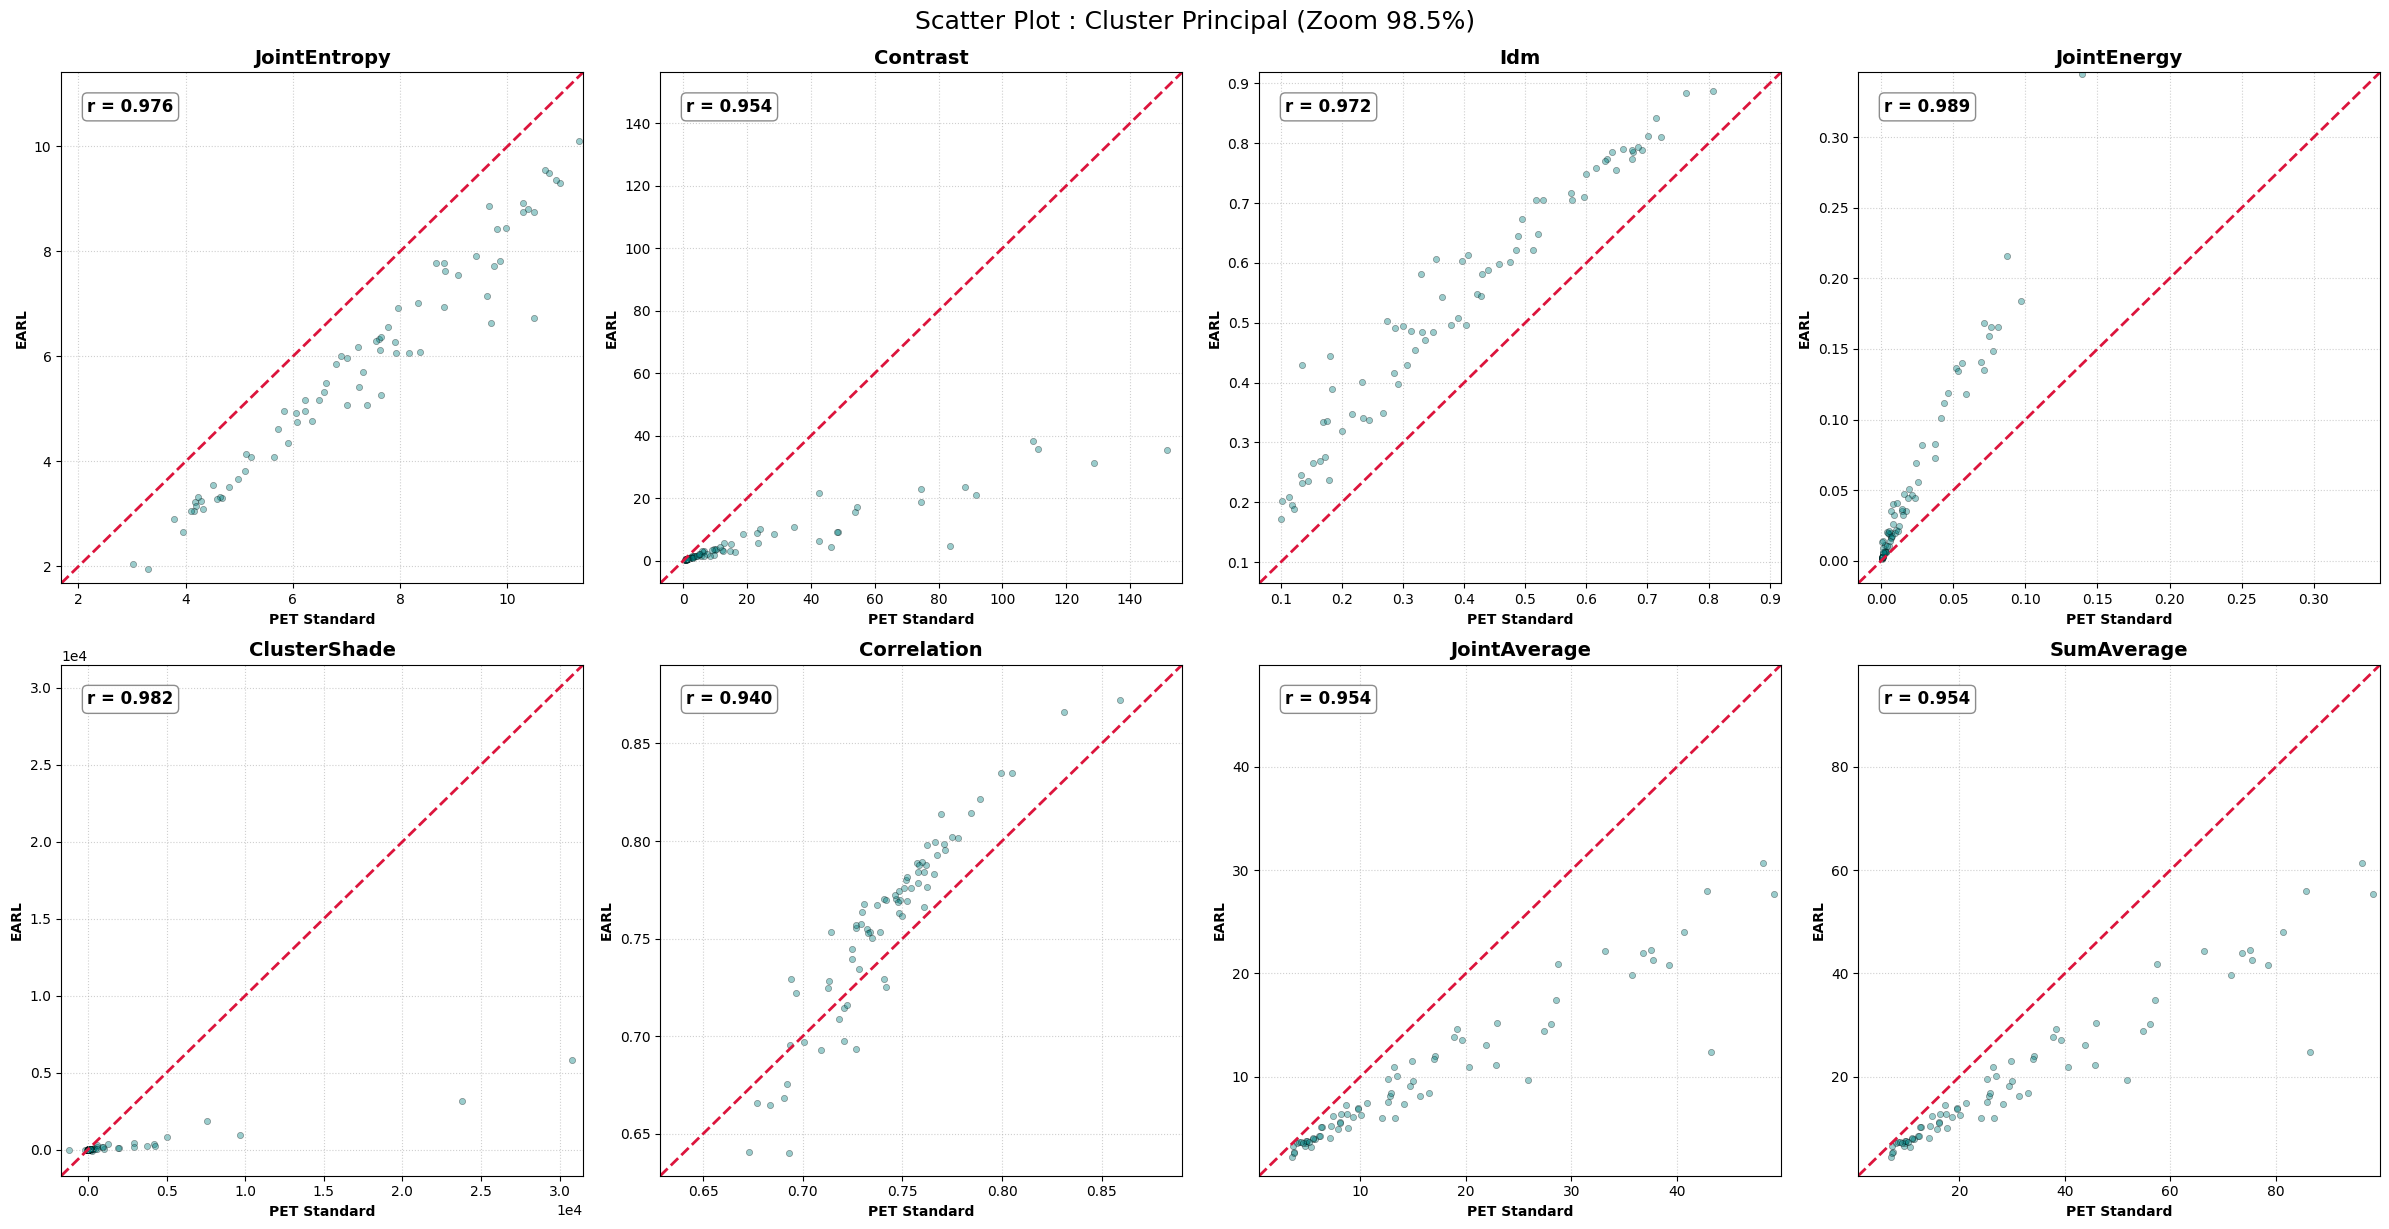

In [20]:
plot_scatter_identity(liver_final_dataframe, FEATURES_GLCM, zoom_percentile=0.75)

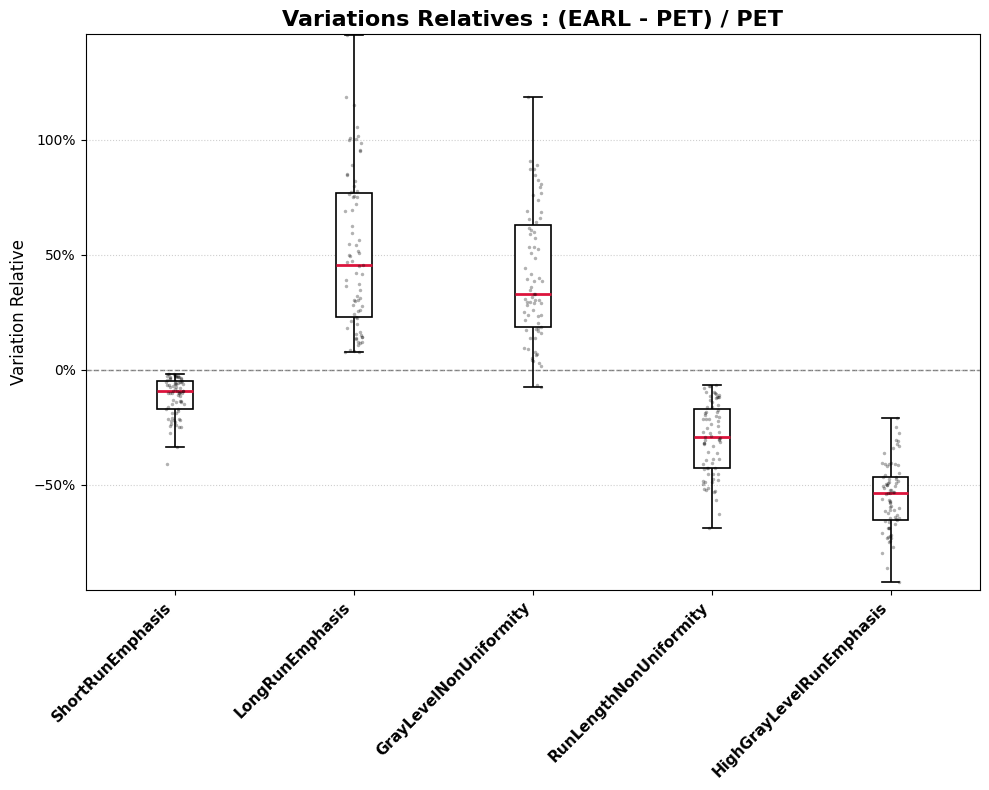

In [120]:
plot_delta_boxplot(liver_final_dataframe, FEATURES_GLRLM, n_points=300)

## Features GLRLM

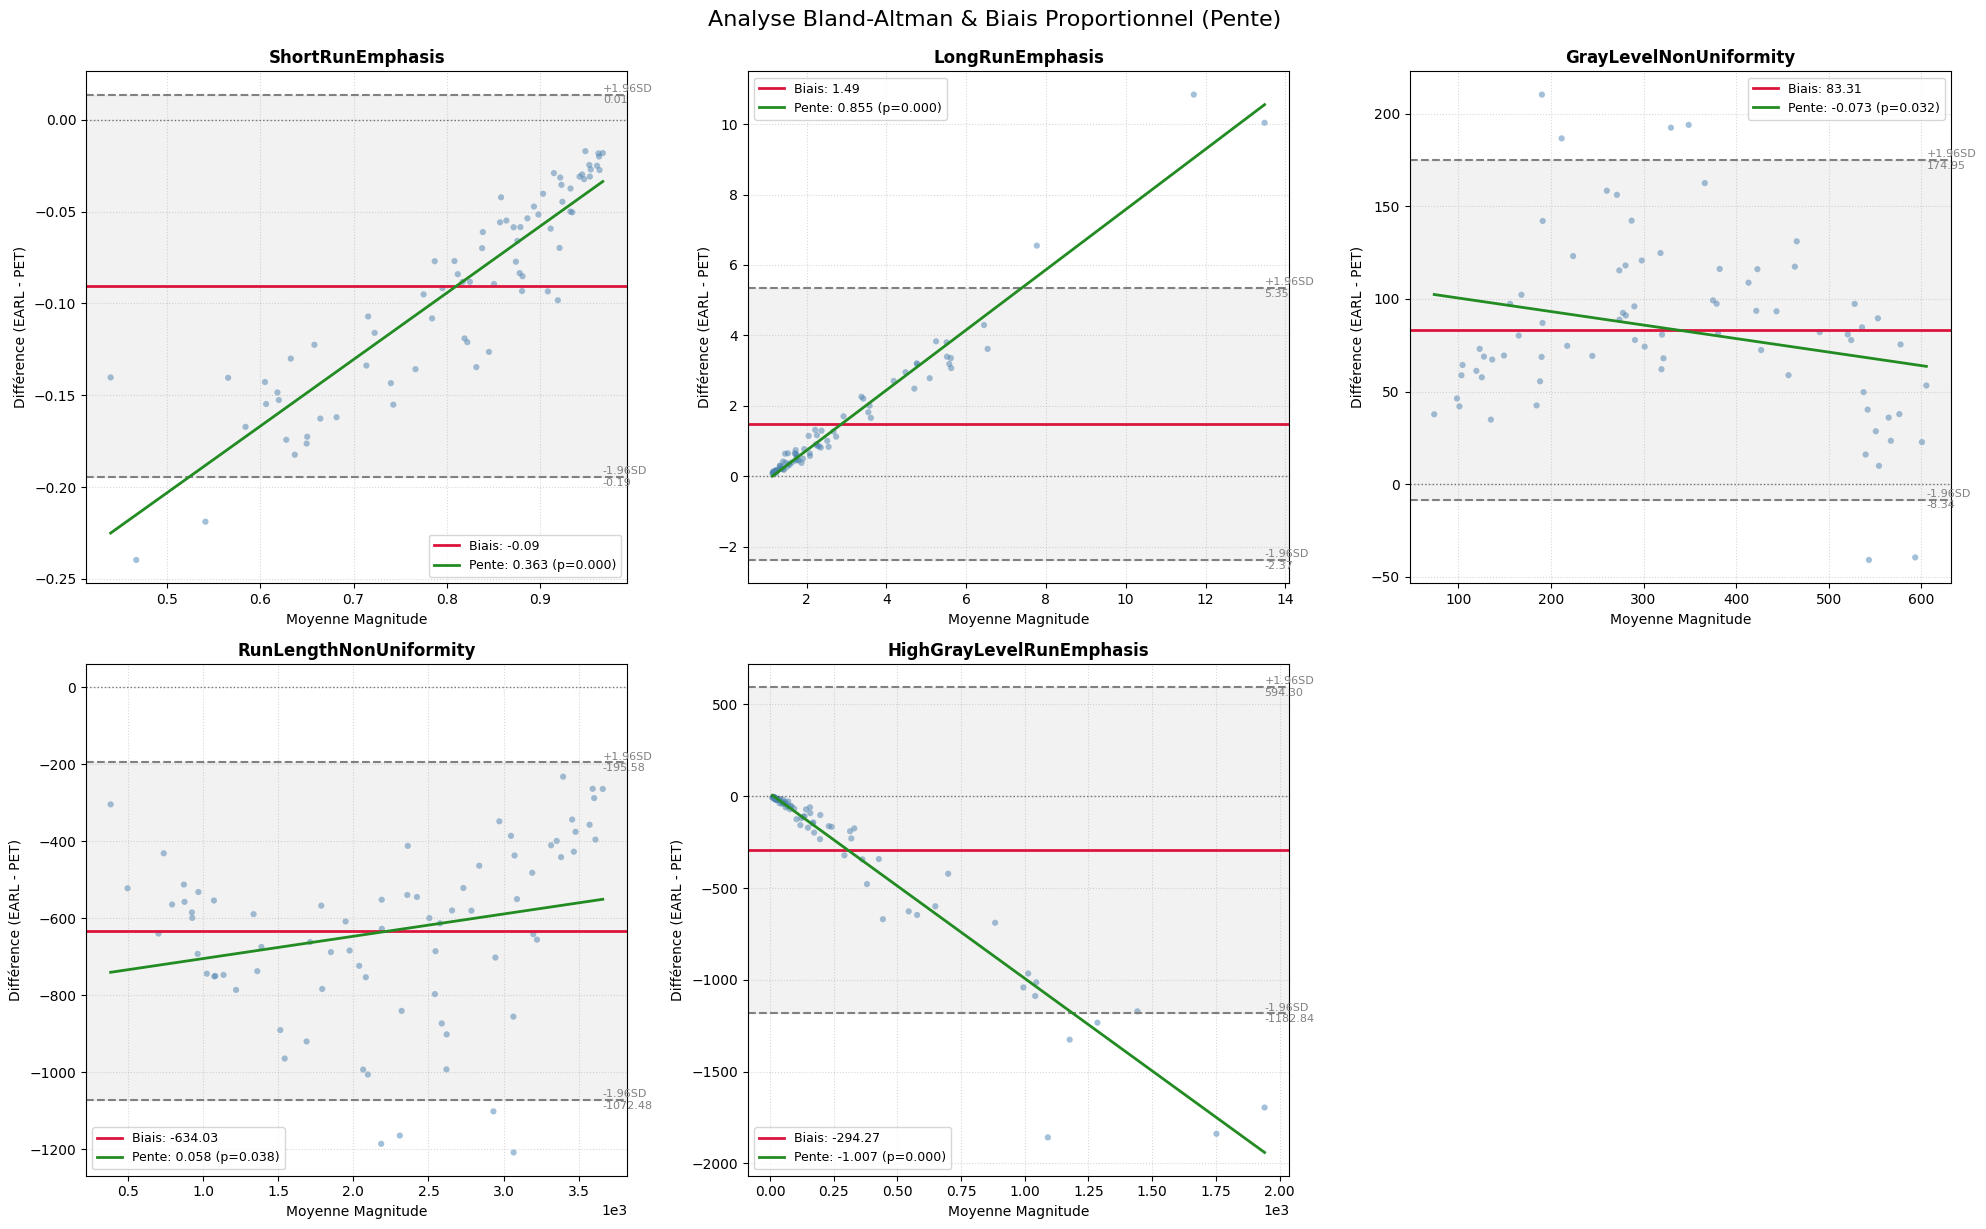

In [121]:
plot_bland_altman_slope(liver_final_dataframe, FEATURES_GLRLM)

### Analyse de la distribution du SUV

In [6]:
import os
import argparse
import logging
import pandas as pd
import numpy as np

from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
from tqdm import tqdm

import SimpleITK as sitk
from scipy.ndimage import distance_transform_edt

# --- CONFIGURATION HISTOGRAMME ---
SUV_MAX = 30.0
N_BINS = 300
BINS = np.linspace(0, SUV_MAX, N_BINS + 1)


def generate_centered_sphere(sitk_mask, radius_mm=20.0, use_barycenter=False, margin_mm=1.0, shift_mm=(0.0, 0.0, 0.0)):
    spacing = sitk_mask.GetSpacing() # (sx, sy, sz)
    origin = sitk_mask.GetOrigin()
    size = sitk_mask.GetSize()
    
    # 2. Calcul de l'origine + Shift
    stats = sitk.LabelShapeStatisticsImageFilter()
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkUInt8)

    stats.Execute(sitk_mask)
    
    if not stats.HasLabel(1):
        return None
        
    if use_barycenter:
        c_phys = list(stats.GetCentroid(1))
    else:
        mask_arr = sitk.GetArrayFromImage(sitk_mask) # (z, y, x)
        edt_map = distance_transform_edt(mask_arr, sampling=spacing[::-1])

        max_idx_flat = edt_map.argmax()
        cz, cy, cx = np.unravel_index(max_idx_flat, mask_arr.shape)
        
        c_phys = list(sitk_mask.TransformIndexToPhysicalPoint((int(cx), int(cy), int(cz))))

    
    c_phys[0] += shift_mm[0]
    c_phys[1] += shift_mm[1]
    c_phys[2] += shift_mm[2]
    
    c_idx = sitk_mask.TransformPhysicalPointToContinuousIndex(c_phys)
    
    nz, ny, nx = size[2], size[1], size[0]
    zz, yy, xx = np.ogrid[:nz, :ny, :nx]
    
    dist2 = (
        ((xx - c_idx[0]) * spacing[0])**2 + 
        ((yy - c_idx[1]) * spacing[1])**2 + 
        ((zz - c_idx[2]) * spacing[2])**2
    )
    
    sphere_arr = (dist2 <= radius_mm**2)

    # Vérification d'inclusion avec marge
    safety_radius_sq = (radius_mm + margin_mm)**2
    safety_arr = (dist2 <= safety_radius_sq)

    if not np.any(sphere_arr):
        return None

    mask_arr = sitk.GetArrayFromImage(sitk_mask).astype(bool)

    if not np.all(mask_arr[safety_arr]):
        return None

    # 8. Conversion et retour
    out_sitk = sitk.GetImageFromArray(sphere_arr.astype(np.uint8))
    out_sitk.CopyInformation(sitk_mask)
    
    return out_sitk


def process_single_subject(args):
    subject_id, root_dir, mask_filename, sphere_radius = args
    
    subject_path = os.path.join(root_dir, subject_id)
    mask_path = os.path.join(subject_path, mask_filename)

    if not os.path.exists(mask_path):
        return f"SKIP: Masque introuvable pour {subject_id}"

    try:
        # 1. Chargement et Génération Sphère
        original_mask = sitk.ReadImage(mask_path)
        sphere_mask_sitk = generate_centered_sphere(
            original_mask, radius_mm=sphere_radius, use_barycenter=False, margin_mm=1.0
        )
        
        if sphere_mask_sitk is None:
            return f"SKIP: Sphère invalide pour {subject_id}"

        # 2. Identification des fichiers (PET et EARL)
        files = os.listdir(subject_path)
        pt_file = next((f for f in files if f.startswith('PET') and 'EARL' not in f and 'MIP' not in f), None)
        earl_file = next((f for f in files if f.startswith('EARL') and 'MIP' not in f), None)

        if not pt_file or not earl_file:
            return f"SKIP: Manque PET ou EARL pour {subject_id}"
        
        # 3. Lecture des Images et Application du Masque
        # On lit directement l'array pour aller vite
        pet = sitk.ReadImage(os.path.join(subject_path, pt_file))
        earl = sitk.ReadImage(os.path.join(subject_path, earl_file))
        
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(pet)
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        sphere_mask_sitk_resampled = resampler.Execute(sphere_mask_sitk)

        # Conversion du masque sphère en booléen numpy
        mask_arr = sitk.GetArrayFromImage(sphere_mask_sitk_resampled)
        
        arr_pet = sitk.GetArrayFromImage(pet)
        arr_earl = sitk.GetArrayFromImage(earl)

        vals_pet = arr_pet[mask_arr == 1]
        vals_earl = arr_earl[mask_arr == 1]

        assert vals_pet.size > 0, "Sphère PET vide"
        assert all([sp == se for sp, se in zip(vals_pet.shape, vals_earl.shape)]), "Taille PET/EARL incompatible"

        # 4. Calcul de l'histogramme local (Somme des occurences)
        hist_pet, _ = np.histogram(vals_pet, bins=BINS)
        hist_earl, _ = np.histogram(vals_earl, bins=BINS)

        # On retourne les deux tableaux numpy
        return (hist_pet, hist_earl)

    except Exception as e:
        return f"ERR: {subject_id} - {e}"


def process_subjects(root_dir, mask_filename, sphere_radius=20.0):
    total_hist_pet = np.zeros(N_BINS, dtype=np.float64)
    total_hist_earl = np.zeros(N_BINS, dtype=np.float64)
    count_valid = 0

    if not mask_filename.endswith(('.nii', '.nii.gz')):
        mask_filename += '.nii.gz'

    # Lister les sujets
    subjects = sorted([s for s in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, s))])
    
    # Config Workers (Laisser 2 coeurs libres pour le système)
    num_workers = max(1, multiprocessing.cpu_count() // 2)
    
    logging.info(f"Traitement de {len(subjects)} sujets avec {num_workers} workers 🚀")

    # Préparation des tâches
    tasks = [(subject, root_dir, mask_filename, sphere_radius) for subject in subjects]

    # Lancement Parallèle
    print("Calcul des histogrammes sur sphères...")
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_single_subject, task): task for task in tasks}
        
        for future in tqdm(as_completed(futures), total=len(tasks)):
            result = future.result()
            
            # Si c'est un tuple, c'est que ça a marché (hist_pet, hist_earl)
            if isinstance(result, tuple):
                h_pet, h_earl = result
                total_hist_pet += h_pet
                total_hist_earl += h_earl
                count_valid += 1
            # Sinon c'est un message d'erreur (string)
            elif isinstance(result, str) and "ERR" in result:
                print(result) # On affiche juste les vraies erreurs


    return total_hist_pet, total_hist_earl, count_valid
    

total_hist_pet, total_hist_earl, count_valid = process_subjects(
    root_dir='./data/PET-EARL/Rennes_Nifti_resampled/',
    mask_filename='liver.nii.gz',
    sphere_radius=20.0
)

print(f"\nHistogramme généré sur {count_valid} patients.")


Calcul des histogrammes sur sphères...


100%|██████████| 77/77 [02:47<00:00,  2.17s/it] 


Histogramme généré sur 75 patients.


## Affichage sur le foie

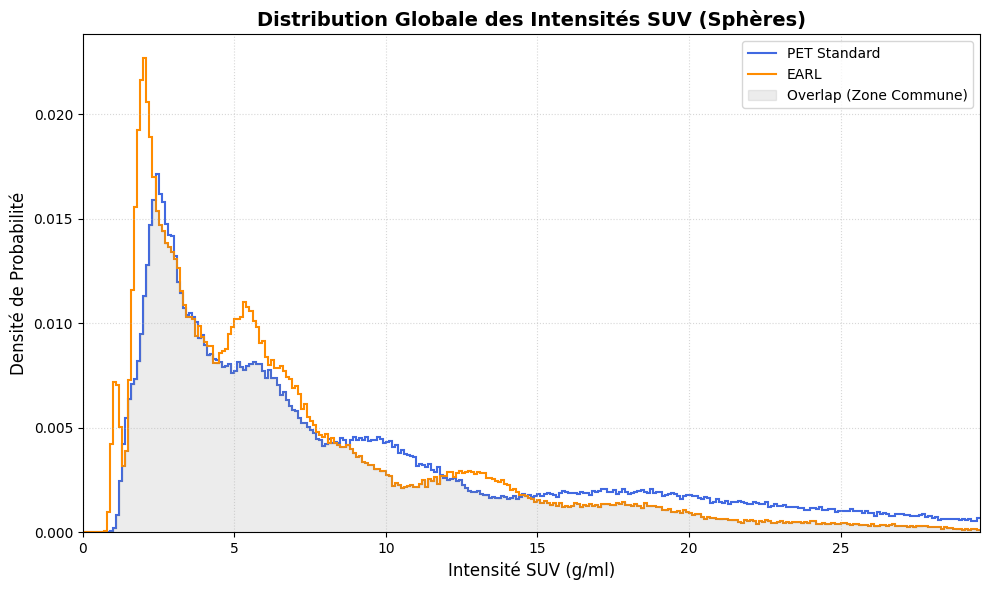

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_suv_distribution_step(total_hist_pet, total_hist_earl, bins):
    sum_pet = total_hist_pet.sum()
    sum_earl = total_hist_earl.sum()
    
    # Sécurité division par zéro
    dens_pet = total_hist_pet / sum_pet if sum_pet > 0 else total_hist_pet
    dens_earl = total_hist_earl / sum_earl if sum_earl > 0 else total_hist_earl
    
    # 2. Création de la Figure
    plt.figure(figsize=(10, 6))
    
    # 3. Tracé des Lignes en Escalier (plt.stairs)
    plt.stairs(dens_pet, bins, color='royalblue', linewidth=1.5, label='PET Standard')
    plt.stairs(dens_earl, bins, color='darkorange', linewidth=1.5, label='EARL')
    
    # 4. Gestion de l'Overlap (Zone Grise)
    intersection = np.minimum(dens_pet, dens_earl)
    plt.fill_between(bins[:-1], 0, intersection, step='post', 
                     color='gray', alpha=0.15, label='Overlap (Zone Commune)')
    
    # 5. Esthétique Scientifique
    plt.title("Distribution Globale des Intensités SUV (Sphères)", fontsize=14, fontweight='bold')
    plt.xlabel("Intensité SUV (g/ml)", fontsize=12)
    plt.ylabel("Densité de Probabilité", fontsize=12)
    
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(loc='upper right', frameon=True, fontsize=10)
    
    # 6. Zoom Intelligent sur l'axe X
    # On coupe l'affichage là où il n'y a plus de données (99.5% de la masse)
    # Cela évite d'afficher une ligne plate jusqu'à SUV=30 si tout est concentré à 3.
    cumsum_ref = np.cumsum(dens_pet)
    limit_idx = np.searchsorted(cumsum_ref, 0.995)
    
    # On prend la borne correspondante + une petite marge
    if limit_idx < len(bins) - 1:
        plt.xlim(0, bins[limit_idx + 5]) 
    else:
        plt.xlim(0, bins[-1])

    plt.tight_layout()
    plt.show()


SUV_MAX = 30.0
N_BINS = 300
BINS = np.linspace(0, SUV_MAX, N_BINS + 1)

plot_suv_distribution_step(total_hist_pet, total_hist_earl, BINS)

## Affichage sur le cerveau

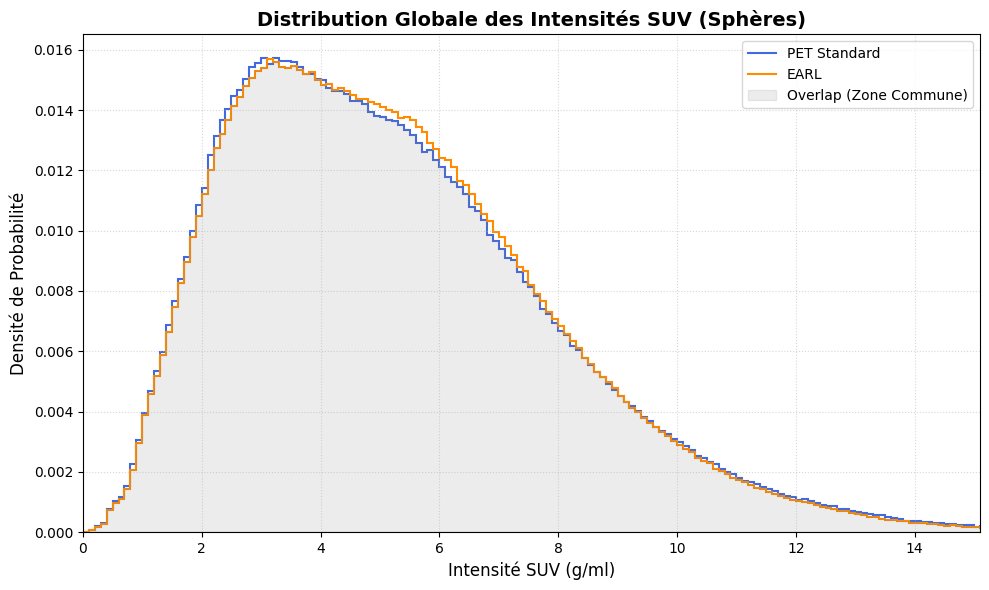

In [6]:
# --- EXEMPLE D'APPEL ---
SUV_MAX = 30.0
N_BINS = 300
BINS = np.linspace(0, SUV_MAX, N_BINS + 1)

plot_suv_distribution_step(total_hist_pet, total_hist_earl, BINS)

## ------------------------ Comparison d'un unique patient (EARL predite) ------------------------

In [5]:
# --- 1. FIRST ORDER (9 Features) ---
# Focus : Quantification (Median/Energy), Bruit (Entropy/Uniformity), Forme de l'histogramme (Skew/Kurt)
FEATURES_FIRSTORDER = [
    'original_firstorder_Entropy',                    # Mesure du désordre (Bruit) -> Doit Baisser
    'original_firstorder_Uniformity',                 # Mesure de l'ordre -> Doit Monter
    'original_firstorder_RobustMeanAbsoluteDeviation',# Dispersion robuste -> Doit Baisser
    'original_firstorder_MeanAbsoluteDeviation',      # Dispersion globale -> Doit Baisser
    'original_firstorder_Median',                     # Intensité Moyenne (Biologie) -> Doit rester Stable
    'original_firstorder_Maximum',                    # Pics d'intensité (Points chauds) -> Doit Baisser (si PSF)
    'original_firstorder_Kurtosis',                   # Aplatissement de la courbe -> Doit se normaliser
    'original_firstorder_Skewness',                   # Asymétrie de la courbe -> Doit tendre vers 0
    'original_firstorder_Energy'                      # Masse totale du signal -> Doit rester cohérente
]

# --- 2. GLCM (8 Features) ---
# Focus : Texture fine, Contraste local et Intensité moyenne
FEATURES_GLCM = [
    'original_glcm_JointEntropy',    # Complexité texturelle -> Doit Baisser
    'original_glcm_Contrast',        # Différence d'intensité locale -> Doit Baisser
    'original_glcm_Idm',             # Homogénéité (Inverse Diff Moment) -> Doit Monter
    'original_glcm_JointEnergy',     # Uniformité texturelle (Ang. Sec. Moment) -> Doit Monter
    'original_glcm_ClusterShade',    # Asymétrie de la texture -> Stable ou légère baisse
    'original_glcm_Correlation',     # Structure linéaire -> Stable
    'original_glcm_JointAverage',    # Proxy du SUV Mean -> Stable (Ligne Identité parfaite attendue)
    'original_glcm_SumAverage'       # Proxy du SUV Mean -> Stable
]

# --- 3. GLRLM (5 Features) ---
# Focus : "Courses" de pixels (Run Length). 
# Idée : Le bruit crée des courses courtes. Le lissage crée des courses longues.
FEATURES_GLRLM = [
    'original_glrlm_ShortRunEmphasis',       # (SRE) Prédominance des lignes courtes (Bruit) -> Doit Baisser NETTEMENT
    'original_glrlm_LongRunEmphasis',        # (LRE) Prédominance des lignes longues (Lisse) -> Doit Monter
    'original_glrlm_GrayLevelNonUniformity', # (GLN) Variabilité des gris -> Doit Baisser
    'original_glrlm_RunLengthNonUniformity', # (RLN) Variabilité des longueurs -> Doit Baisser
    'original_glrlm_HighGrayLevelRunEmphasis'# (HGLRE) Texture dans les zones chaudes -> À surveiller (Conservation du signal tumeur)
]

In [ ]:
df = pd.read_csv('./data/PET-EARL/temp/9401165330m/liver_sphere_radiomics.csv')

# Mapping des noms
modality_map = {
    'PET_Standard': 'PET',
    'PET_Predicted': 'Predicted',
    'PET_EARL': 'EARL'
}

# Filtrage et renommage
plot_df = df[df['Modality'].isin(modality_map.keys())].copy()
plot_df['Modality'] = plot_df['Modality'].map(modality_map)

# Ordre logique pour voir l'évolution : PET (Départ) -> Predicted (Résultat) -> EARL (Cible)
order = ['PET', 'Predicted', 'EARL']
colors = ['red', 'green', 'blue'] # Ou palette seaborn

# 2. Création de la figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(FEATURES_FIRSTORDER):
    ax = axes[i]
    
    # On utilise pointplot pour afficher la moyenne (le point) et l'intervalle de confiance (si plusieurs données)
    # Si tu as une seule ligne par modalité, cela affichera juste le point unique.
    sns.pointplot(
        x='Modality', 
        y=feature, 
        data=plot_df, 
        order=order,
        ax=ax,
        markers='o',       # Forme du point
        linestyles='-',    # Ligne pour relier et voir la pente
        errorbar=None,     # Enlève les barres d'erreur pour un look plus épuré "3 points"
        # color='black',     # Ligne noire
        capsize=0.1,
        hue='Modality',
    )
    
    # Ajout d'un stripplot par dessus pour voir les vrais points individuels (si tu en as plusieurs)
    # Utile pour vérifier la dispersion. Si tu n'as qu'une valeur, ça superpose juste un point coloré.
    sns.stripplot(
        x='Modality', 
        y=feature, 
        data=plot_df, 
        order=order,
        ax=ax,
        size=8,
        palette={'PET': 'salmon', 'Predicted': 'lightgreen', 'EARL': 'skyblue'},
        edgecolor='gray',
        linewidth=1,
        hue='Modality',
    )

    # Esthétique
    title = feature.replace('original_firstorder_', '')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Trajectoire d\'Harmonisation : PET -> Predicted -> EARL', y=1.02, fontsize=16)
plt.show()